# 0.0 IMPORTS

In [132]:
import pandas as pd
import inflection
import math
import numpy as np

import datetime

import seaborn as sns
import matplotlib.pyplot as plt

from IPython.display import Image
from IPython.core.display import HTML

## 0.1. Helper functions
In this section, we define some functions that will help us along the project.

In [133]:
# sets seaborn style
sns.set_style("darkgrid")
sns.set_palette("muted")

# sets matplolit inline
%matplotlib inline

# sets to display unlimited number of columns
pd.options.display.max_columns = None

# setting the title and axis labels
def set_plots_features(ax, title, xlabel, ylabel):
    ax.set_title(title, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)


# cramér V
def cramer_v(var_x, var_y):
    # builds contigency matrix (or confusion matrix)
    confusion_matrix = pd.crosstab(var_x, var_y).values
    
    # gets the sum of all values in the matrix
    n = confusion_matrix.sum()
    
    # gets the rows, cols
    r, k = confusion_matrix.shape
    
    # gets the chi-squared
    chi2 = chi2_contingency(confusion_matrix)[0]
    
    # makes the bias correction
    chi2corr = max(0, chi2 - (k-1) * (r-1) / (n-1))
    kcorr = k - (k-1) ** 2 / (n-1)
    rcorr = r - (r-1) ** 2 / (n-1)
    
    # returns cramér V
    return np.sqrt((chi2corr/n) / min(kcorr-1, rcorr-1))

Other optional settings that could be applied.

```python
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figzise'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display(HTML('<style>.container {width:100% !important;}</style>'))
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    sns.set()
```

## 0.2 Loading dada
In this section, we import the data.

In [9]:
# loads train dataset
df_sales_raw = pd.read_csv('data/train.csv', low_memory=False)

# loads store dataset
df_store_raw = pd.read_csv('data/store.csv', low_memory=False)

# merge the two datasets into one
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [10]:
# checks the operations
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
195051,1042,6,2015-02-07,2331,375,1,0,0,0,a,a,3440.0,NaN,NaN,1,31.0,2013.0,"Feb,May,Aug,Nov"


# 1.0 DATA DESCRIPTION

Let's take a look at data field descriptions from Kaggle.

https://www.kaggle.com/c/rossmann-store-sales/data

**Data fields**

Most of the fields are self-explanatory. The following are descriptions for those that aren't.

- **Id** - an Id that represents a (Store, Date) duple within the test set
- **Store** - a unique Id for each store
- **Sales** - the turnover for any given day (this is what you are predicting)
- **Customers** - the number of customers on a given day
- **Open** - an indicator for whether the store was open: 0 = closed, 1 = open
- **StateHoliday** - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None
- **SchoolHoliday** - indicates if the (Store, Date) was affected by the closure of public schools
- **StoreType** - differentiates between 4 different store models: a, b, c, d
- **Assortment** - describes an assortment level: a = basic, b = extra, c = extended
- **CompetitionDistance** - distance in meters to the nearest competitor store
- **CompetitionOpenSince[Month/Year]** - gives the approximate year and month of the time the nearest competitor was opened
- **Promo** - indicates whether a store is running a promo on that day
- **Promo2** - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating
- **Promo2Since[Year/Week]** - describes the year and calendar week when the store started participating in Promo2
- **PromoInterval** - describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

### 1.0.1 Project initial checkpoint

In [11]:
# checks the dataset
df_raw

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
0,1,5,2015-07-31,5263,555,1,1,0,1,c,a,1270.0,9.0,2008.0,0,NaN,NaN,NaN
1,2,5,2015-07-31,6064,625,1,1,0,1,a,a,570.0,11.0,2007.0,1,13.0,2010.0,"Jan,Apr,Jul,Oct"
2,3,5,2015-07-31,8314,821,1,1,0,1,a,a,14130.0,12.0,2006.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"
3,4,5,2015-07-31,13995,1498,1,1,0,1,c,c,620.0,9.0,2009.0,0,NaN,NaN,NaN
4,5,5,2015-07-31,4822,559,1,1,0,1,a,a,29910.0,4.0,2015.0,0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,a,a,1900.0,6.0,2014.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"
1017205,1112,2,2013-01-01,0,0,0,0,a,1,c,c,1880.0,4.0,2006.0,0,NaN,NaN,NaN
1017206,1113,2,2013-01-01,0,0,0,0,a,1,a,c,9260.0,NaN,NaN,0,NaN,NaN,NaN
1017207,1114,2,2013-01-01,0,0,0,0,a,1,a,c,870.0,NaN,NaN,0,NaN,NaN,NaN


In [12]:
# makes a copy from original DataFrame, so we can separate the dataset manipulation by section
df1 = df_raw.copy()

## 1.1. Renaming columns
Rename columns to make easier to understand and work with them.

In [13]:
# checks the columns in out dataset
df1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [14]:
# stores the old column names
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 
            'SchoolHoliday', 'StoreType', 'Assortment','CompetitionDistance', 'CompetitionOpenSinceMonth', 
            'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval']

# snake_case
snakecase = lambda x: inflection.underscore(x)

# creates new columns from old columns in snakecase 
cols_new = list(map(snakecase, cols_old))

# renames the old columns
df1.columns = cols_new

In [15]:
# checks the operations
df1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2.  Checking data dimensions
Verifies the number of rows and columns in the dataset.

In [16]:
print('Number of rows: {}'.format(df1.shape[0]))
print('Number of cols: {}'.format(df1.shape[1]))

Number of rows: 1017209
Number of cols: 18


## 1.3.  Checking data types
Verifies the dataset data types.

In [17]:
df1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [18]:
# transforms 'date' column to datetime type
df1['date'] = pd.to_datetime(df1['date'])
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4.  Checking NaN values
Verifies the presence of missing values.

In [19]:
df1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

We noticed that we have a lot of missing data. We can chosse one of the following three paths:

**1) Exclude all lines that have missing data**, but we may lose important information that the ML algorithm may need and negatively impact the forecasting.

**2) Use ML techniques to fill in the missing data** and predict what value would replace the `NaN`. This method is good when we don't have business information available.

**3) Really understand the business.** Understand the business rules and fill in the missing data with relevant information.

## 1.5.  Filling out the NaN values
We chose the method 3 (understand the business).

### 1.5.1 Filling the competition data

In [20]:
# checks the maximum distance to the nearest competitor
df1['competition_distance'].max()

75860.0

In [21]:
# competition_distance
# let's assume that the distance from competitors is so long that there are no competitors
# applies for each column record: competition_distance
#     assign 200000.0 if record == NaN ; assign its current value if record != NaN
df1['competition_distance'] = df1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# competition_open_since_month
# let's assume that the opening date is the store sales date: date
# axis=1 -> apply in the row along the columns, because we have more than one column in the expression
df1['competition_open_since_month'] = df1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

# competition_open_since_year 
df1['competition_open_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

In [22]:
# checks the operations
df1.sample(5).T

,573919,981726,642948,539631,773363
store,480,197,379,757,339
day_of_week,7,5,1,3,3
date,2014-02-02 00:00:00,2013-02-01 00:00:00,2013-12-02 00:00:00,2014-03-05 00:00:00,2013-08-07 00:00:00
sales,0,7201,6829,7137,4076
customers,0,943,690,585,589
open,0,1,1,1,1
promo,0,0,1,1,0
state_holiday,0,0,0,0,0
school_holiday,0,1,0,0,1
store_type,a,c,d,a,a


### 1.5.2 Filling the promotion data

In [23]:
# promo2_since_week
df1['promo2_since_week'] = df1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

# promo2_since_year
df1['promo2_since_year'] = df1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

In [24]:
# promo_interval

# creates a dictionary that will help in mapping
month_map = {1: 'Jan', 2: 'Fev', 3: 'Mar', 4: 'Apr', 5: 'May', 6: 'Jun',
             7: 'Jul', 8: 'Aug', 9: 'Sep', 10: 'Oct', 11: 'Nov', 12: 'Dec'}

# fills in the NaN with zeroes
df1['promo_interval'].fillna(0, inplace=True)

# creates the 'month_map' column as the month mapping of the 'date' column
df1['month_map'] = df1['date'].dt.month.map(month_map)

In [25]:
# checks the operations
df1.sample(5).T

,2663,777261,367160,135399,698229
store,434,892,975,485,1025
day_of_week,3,7,4,3,1
date,2015-07-29 00:00:00,2013-08-04 00:00:00,2014-08-14 00:00:00,2015-04-01 00:00:00,2013-10-14 00:00:00
sales,10680,0,6709,6306,6467
customers,649,0,731,475,846
open,1,0,1,1,1
promo,1,0,0,1,0
state_holiday,0,0,0,0,0
school_holiday,0,0,1,1,1
store_type,a,a,a,d,a


In [26]:
# make a split in 'promo_interval' column and creates a list containing the values
# check if the value of 'month_map' is within that list
# creates column 'is_promo' with numeric values (1 = was in promo or 0 = was not in promo) based on the verification
df1['is_promo'] = df1[['promo_interval','month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

In [27]:
# checks the operations
df1.sample(5).T

,712647,541450,789220,10946,811544
store,948,346,586,912,610
day_of_week,2,1,3,3,4
date,2013-10-01 00:00:00,2014-03-03 00:00:00,2013-07-24 00:00:00,2015-07-22 00:00:00,2013-07-04 00:00:00
sales,5791,5109,11261,4487,5937
customers,1548,387,2019,605,592
open,1,1,1,1,1
promo,0,1,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,1,1,0
store_type,b,a,a,c,a


### 1.5.4 Checking the final values

In [28]:
# checks the operations
df1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.6.  Changing data types

In [29]:
# checks columns data types
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

We notice that the following columns are `float64`:
- `competition_open_since_month`
- `competition_open_since_year`
- `promo2_since_week` 
- `promo2_since_year` 

However, they are actually `int` values as they represent months and years which are discrete values. Thus, we can do:

In [30]:
# transforms competition data to int
df1['competition_open_since_month'] = df1['competition_open_since_month'].astype(int)
df1['competition_open_since_year'] = df1['competition_open_since_year'].astype(int)

# transforms promotion data to int
df1['promo2_since_week'] = df1['promo2_since_week'].astype(int)
df1['promo2_since_year'] = df1['promo2_since_year'].astype(int)

In [31]:
# checks the operations
df1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

## 1.7. Descriptive Statistics

It is through the descriptive statistics that we are able to get a notion from the business. It helps detect some errors.

Thereare two big metrics that we have to keep our eyes on: **data distribution and central tendency**.

**Central tendency:** summary statistics like median, mean, max, min, quantiles.

**Data distribution:** we need to know how the data is distributed around the median and mean.

Other important statistics: **skewness and kurtosis**.

Also, check how variabless behave and look for negative values that shouldn't be.

In [32]:
# creates a dataset for numerical attributes
num_attributes = df1.select_dtypes(include=['int64','float64'])

# creates a dataset for categorical attributes
cat_attributes = df1.select_dtypes(exclude=['int64','float64', 'datetime64[ns]'])

In [33]:
# checks the operation
num_attributes.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
821460,491,2,4629,400,1,0,0,4680.0,6,2013,1,22,2012,1
217646,222,6,2904,360,1,0,0,2170.0,11,2008,0,3,2015,0


In [34]:
# checks the operation
cat_attributes.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
453849,0,a,c,"Jan,Apr,Jul,Oct",May
534133,0,a,a,0,Mar


### 1.7.1 Numerical attributes

In [35]:
# central tendency: mean, median
mean = pd.DataFrame(num_attributes.apply(np.mean)).T
median = pd.DataFrame(num_attributes.apply(np.median)).T

# distribution: std, min, max, range, skew, kurtosis
std = pd.DataFrame(num_attributes.apply(np.std)).T
min_value = pd.DataFrame(num_attributes.apply(min)).T
max_value = pd.DataFrame(num_attributes.apply(max)).T
range_value = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T
skewness = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T
kurtosis = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T

# concatenates
summary_stats = pd.concat([min_value, max_value, range_value, mean, median, std, skewness, kurtosis]).T.reset_index()
summary_stats.columns = ['attributes','min','max','range','mean','median','std','skewness','kurtosis']

In [36]:
# checking the operations
summary_stats

,attributes,min,max,range,mean,median,std,skewness,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


#### Plotting distribution for `sales`

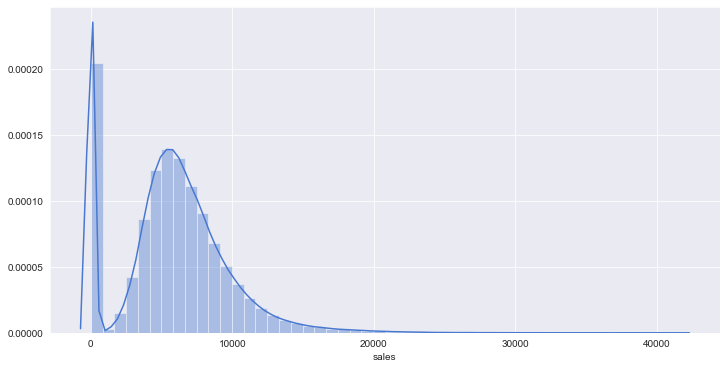

In [37]:
# plots distribution
ax = sns.distplot(df1['sales'])

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

# displays plot
plt.show()

#### Plotting distribution for `competition_distance`

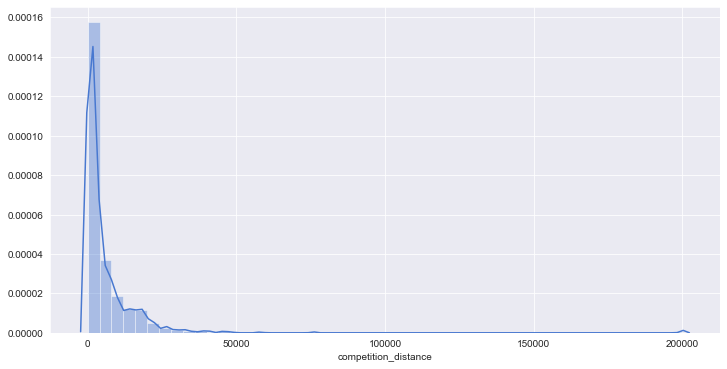

In [38]:
# plots distribution
ax = sns.distplot(df1['competition_distance'])

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

# displays plot
plt.show()

#### Using pandas.describe

In [39]:
num_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
store,1017209.0,558.429727,321.908651,1.0,280.0,558.0,838.0,1115.0
day_of_week,1017209.0,3.998341,1.997391,1.0,2.0,4.0,6.0,7.0
sales,1017209.0,5773.818972,3849.926175,0.0,3727.0,5744.0,7856.0,41551.0
customers,1017209.0,633.145946,464.411734,0.0,405.0,609.0,837.0,7388.0
open,1017209.0,0.830107,0.375539,0.0,1.0,1.0,1.0,1.0
promo,1017209.0,0.381515,0.485759,0.0,0.0,0.0,1.0,1.0
school_holiday,1017209.0,0.178647,0.383056,0.0,0.0,0.0,0.0,1.0
competition_distance,1017209.0,5935.442677,12547.652996,20.0,710.0,2330.0,6910.0,200000.0
competition_open_since_month,1017209.0,6.786849,3.311087,1.0,4.0,7.0,10.0,12.0
competition_open_since_year,1017209.0,2010.324840,5.515593,1900.0,2008.0,2012.0,2014.0,2015.0


### 1.7.1 Categorical attributes

In [40]:
# checks how many types we have for each atribute
cat_attributes.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

#### Plotting boxplots for `state_holiday`, `store_type` and `assortment` in relation to `sales`

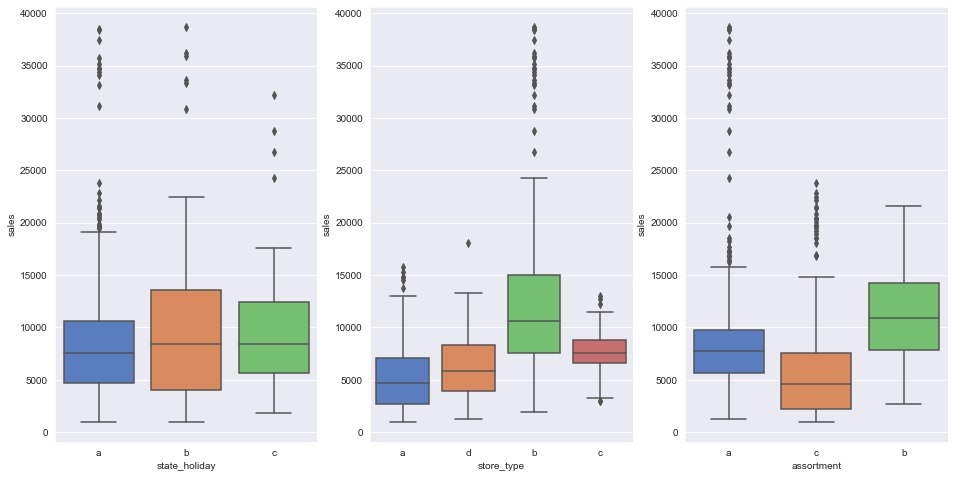

In [41]:
# filters the data that we want to display
# as we don't want to see all the days on which the stores were closed
aux1 = df1[(df1['state_holiday'] != '0') & (df1['sales'] > 0)]

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

plt.subplot(1, 3, 1)
ax = sns.boxplot(x='state_holiday', y='sales', data=aux1)

plt.subplot(1, 3, 2)
ax = sns.boxplot(x='store_type', y='sales', data=aux1)

plt.subplot(1, 3, 3)
ax = sns.boxplot(x='assortment', y='sales', data=aux1)

# displays plot
plt.show()

# 2.0 FEATURE ENGINEERING

### 2.0.1 Project Checkpoint
Let's save our progress and make a checkpoint in our project by making a copy of `df1`. So we don't have to run everything from the start. We can start from here.

In [42]:
# copies df1 to df2
df2 = df1.copy()

## 2.1 Hypothesis Mindmap
In real life, we draw the mindmap with the stakeholders in a brainstorm-like meeting.

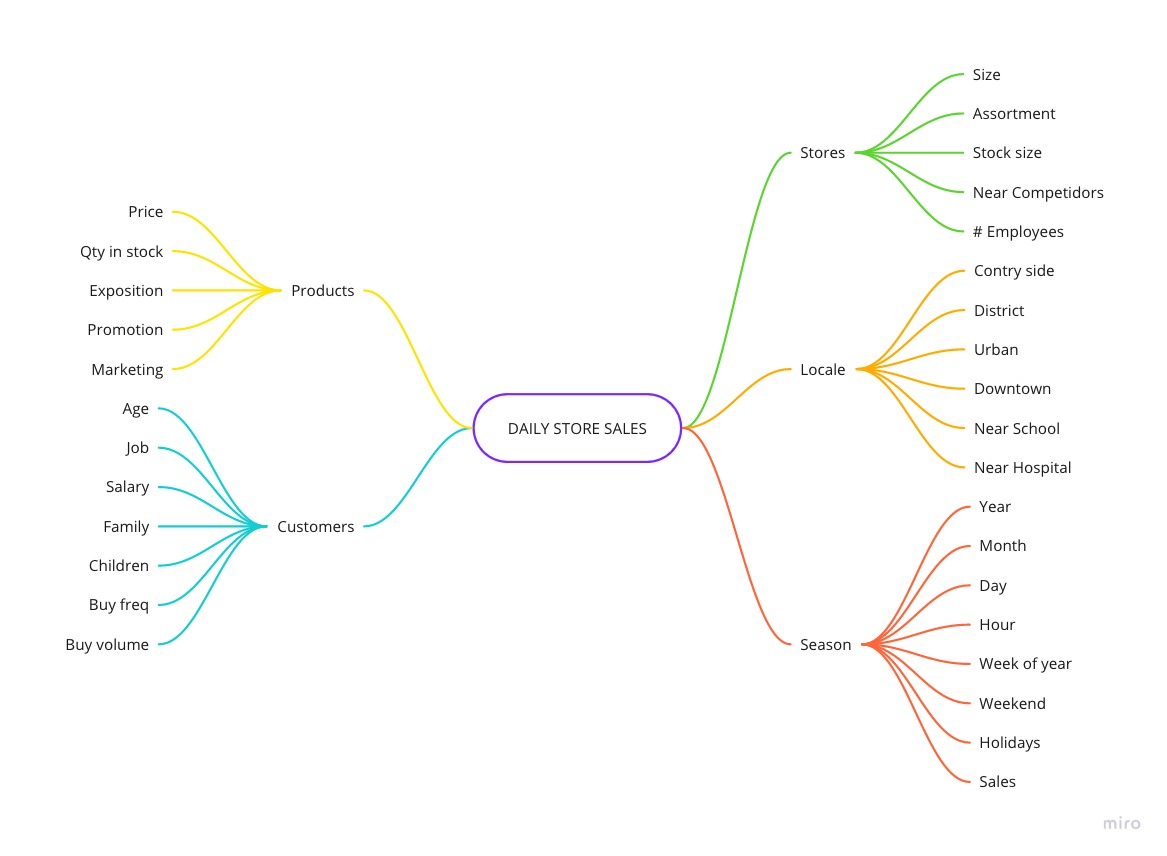

In [43]:
# displays the mindmap
Image('img/hypothesis_map.png')

## 2.2 Creating hypothesis

Creating hypothesis for each variable that you believe that impact in the phenomenon that we are studying, in this case, **Daily Store Sales**, and relate each variable's attributes with the phenomenon.

In real life, we outline the hypothesis in a brainstorm-like meeting with the stakeholders.

### 2.2.1 Store Hypothesis

**1.** Stores with higher number of employees should have higher sales.

**2.** Stores with higher stock should should have higher sales.

**3.** Stores with higher size should should have higher sales.

**4.** Stores with lesser size should have lesser sales.

**5.** Stores with higher assortment should should have higher sales.

**6.** Stores with nearer competitors should have lesser sales.

**7.** Stores with longer competitors should have higher sales.

### 2.2.2 Product Hypothesis

**1.** Stores with higher investments in marketing should have higher sales.

**2.** Stores with higher product exposure should should have higher sales.

**3.** Stores with lesser product prices should should have higher sales.

**4.** Stores with higher discount values should should have higher sales.

**5.** Stores with lesser product prices for longer period of time should should have higher sales.

**6.** Stores with longer period of time in promotion should have higher sales.

**7.** Stores with higher consecutive promotions should have higher sales.

### 2.2.3 Season Hypothesis

**1.** Stores that open on Xmas should have higher sales. 

**2.** Stores should have higher sales along the year.

**3.** Stores should have higher sales on the second semester of the year.

**4.** Stores should have higher sales after the 10th day of the month.

**5.** Stores should have lesser sales on weekends.

**6.** Stores should have lesser sales during school holidays.

## 2.3 Prioritized hypothesis list
We prioritize the hypothesis based on: whether we have or not the data at hand.

There may be data that we don't have it at hand and we need to spend some time on accessing it, collecting it, cleaning it and analyzing it.

**Store**

**1.** Stores with higher assortment should have higher sales.

**2.** Stores with nearer competitors should have lesser sales.

**3.** Stores with longer competitors should have higher sales.

<br>

**Product**

**4.** Stores with lesser product prices for longer period of time should have higher sales.

**5.** Stores with longer period of time in promotion should have higher sales.

**6.** Stores with higher consecutive promotions should have higher sales.

<br>

**Season**

**7.** Stores that open on Xmas should have higher sales. 

**8.** Stores should have higher sales along the years.

**9.** Stores should have higher sales on the second semester of the year.

**10.** Stores should have higher sales after the 10th day of the month.

**11.** Stores should have lesser sales on weekends.

**12.** Stores should have lesser sales during school holidays.

## 2.4 Feature engineering - de facto
In this section, we are going to create some variables (columns) in our dataset to make easier do explore the dataset in the EDA phase.

In [44]:
# year
df2['year'] = df2['date'].dt.year

# month
df2['month'] = df2['date'].dt.month

# day
df2['day'] = df2['date'].dt.day

# week of year
df2['week_of_year'] = df2['date'].dt.weekofyear

# year week
df2['year_week'] = df2['date'].dt.strftime('%Y-%W')

In [45]:
# checks the operations
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [46]:
# competition since

# creates a new datetime column 'competition_since' which is a compound of two columns
# we are specifying that it will always have the 1st day of the month
df2['competition_since'] = df2.apply(lambda x: 
                                     datetime.datetime(year=x['competition_open_since_year'], 
                                                                 month=x['competition_open_since_month'], 
                                                                 day=1), 
                                     axis=1)

In [47]:
# checks the operations
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [48]:
# How many months has passed since the competition store opened?
# gets the difference between columns and divides it by 30 to make the monthly granularity
#     then we get the days as int type
df2['competition_time_month'] = ((df2['date'] - df2['competition_since']) / 30).apply(lambda x: x.days).astype(int)

In [49]:
# checks the operations
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [50]:
# promo since
df2['promo_since'] = df2['promo2_since_year'].astype(str) + '-' +df2['promo2_since_week'].astype(str)

# converts values from 'promo_since' to datetime considering 7 days
df2['promo_since'] = df2['promo_since'].apply(lambda x: 
                         datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - datetime.timedelta(days=7))

# How many weeks has passed since the promotion started?
# OR for how long (in weeks) the promotion is active?
# gets the difference between columns and divides it by 7 to make the weekly granularity
#     then we get the days as int type
df2['promo_time_week'] = ((df2['date'] - df2['promo_since']) / 7).apply(lambda x: x.days).astype(int)

In [51]:
# checks the operations
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


In [52]:
# assortment
# replaces the values to make easier to understand them
df2['assortment'] = df2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

# state holiday
# replaces the values to make easier to understand them
df2['state_holiday'] = df2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else 'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

In [53]:
# checks the operations
df2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# 3.0 VARIABLE FILTERING

### 3.0.1 Project Checkpoint
Let's save our progress and make a checkpoint in our project by making a copy of `df2`. So we don't have to run everything from the start. We can start from here.

In [54]:
# copies df2 to df3
df3 = df2.copy()

In [55]:
# checks the dataset
df3.head()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval,month_map,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,555,1,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,625,1,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,821,1,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,"Jan,Apr,Jul,Oct",Jul,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1498,1,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,559,1,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,Jul,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 3.1 Row filtering
We're going to filter the rows first, because the performance is better when fltering the columns later. There are less data to process.

As it makes no sense to get data from closed stores (`open = 0`), we'll consider only the rows where `open = 1` which is the same as saying `'open' != 0`.

As closed stores have 0 sales, we'll consider only the sales from open stores (`open = 1`), that is, `'sales' > 0`.

In [56]:
# gets only the rows for open stores and sales above zero
df3 = df3[(df3['open'] != 0) & (df3['sales'] > 0)]

## 3.2 Column filtering

We don't have the number of `customers` at the moment of the prediction. We would need other ML model to predict it and use it here. The scope of this project will not consider the customers, so we'll classify it as a business restriction.

In the previous step, as we filtered only the rows where `open = 1`, it makes no sense to keep the column `open` because it has only values equal to `1`.

Also, the columns `promo_interval` and `month_map` were only used to derive other columns. Thus, we don't need them anymore.

In [57]:
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']

# drops the columns
df3 = df3.drop(cols_drop, axis=1)

In [58]:
# checks the operation
df3.columns

Index(['store', 'day_of_week', 'date', 'sales', 'promo', 'state_holiday',
       'school_holiday', 'store_type', 'assortment', 'competition_distance',
       'competition_open_since_month', 'competition_open_since_year', 'promo2',
       'promo2_since_week', 'promo2_since_year', 'is_promo', 'year', 'month',
       'day', 'week_of_year', 'year_week', 'competition_since',
       'competition_time_month', 'promo_since', 'promo_time_week'],
      dtype='object')

# 4.0 EXPLORATORY DATA ANALYSIS

### 4.0.1 Project Checkpoint
Let's save our progress and make a checkpoint in our project by making a copy of `df3`. So we don't have to run everything from the start. We can start from here.

In [59]:
# copies df3 to df4
df4 = df3.copy()

In [60]:
# checks the dataset
df4.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0


## 4.1 Univariate analysis

### 4.1.1 Target variable

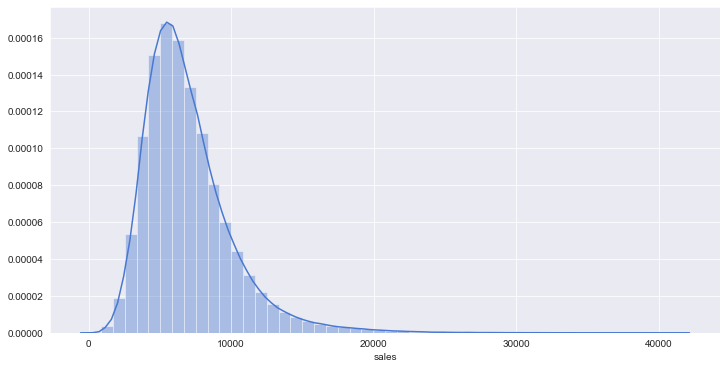

In [61]:
# plots distribution
ax = sns.distplot(df4['sales'])

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

# displays plot
plt.show()

As we can observe, the distribution is **moderately skewed** (`skewness = 0.641460`) and presents a **positive kurtosis** (`1.778375`) which means that we have some possible outliers in our dataset. Thus, the distribution **does not follow a normal distribution**.

As the ML algorithms requires our data to have **independent variables and normal distribution**, we can apply some techniques to do the variable transformation.

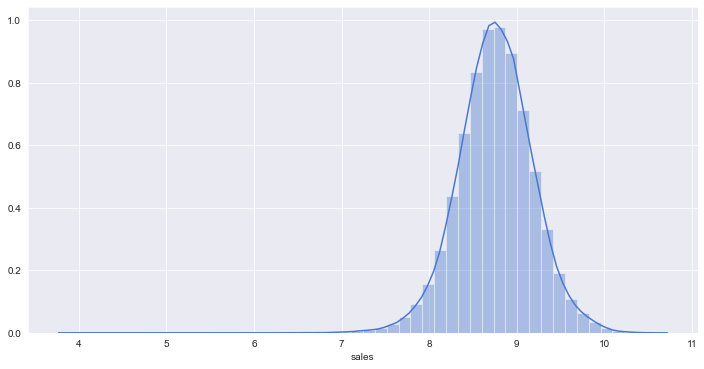

In [62]:
# distribution plotting for 'sales'
# applies log(x + 1) to 'sales'
ax = sns.distplot(np.log1p(df4['sales']))

# setting the figure size in inches
ax.figure.set_size_inches(12, 6)

# display plot
plt.show()

### 4.1.2 Numerical variable (TO DO = Seaborn multi var hist plot)

<ipython-input-63-7d354f504773>:8: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  num_attributes.hist(ax=ax, bins=25);


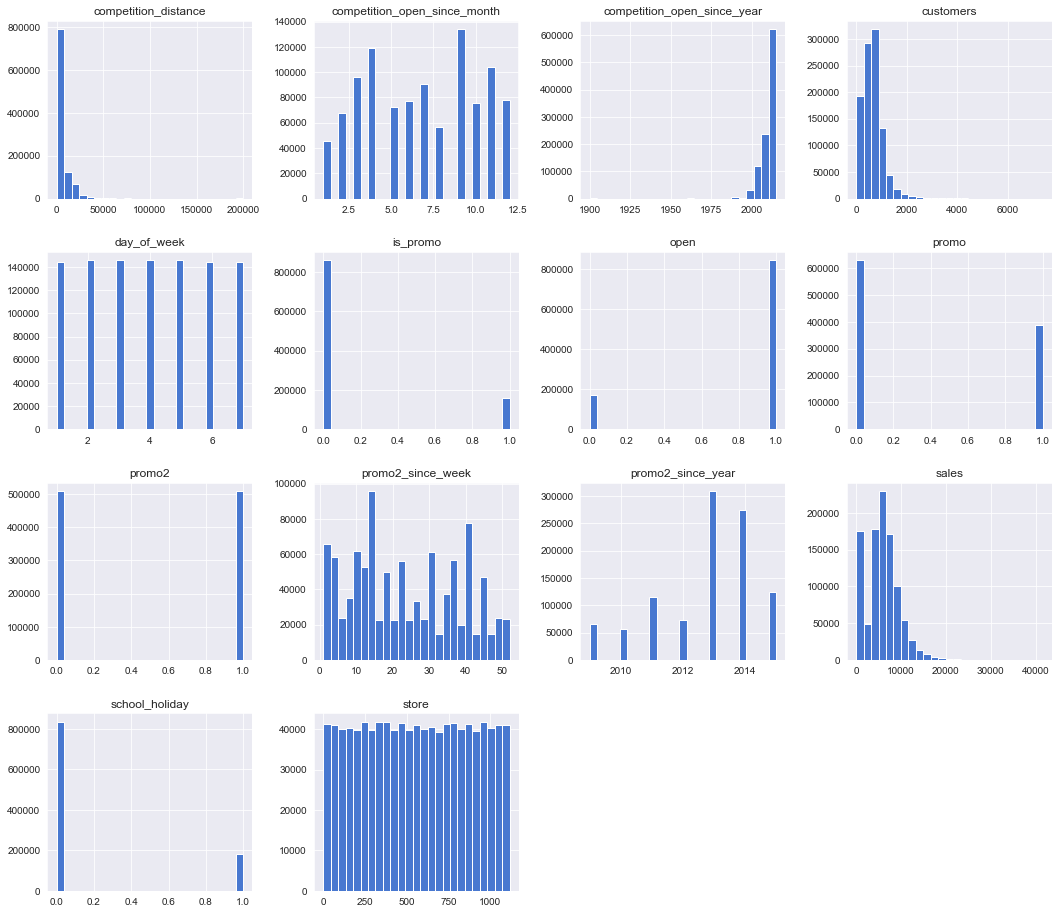

In [63]:
# sets the figure size
fig = plt.figure(figsize = (18,16))

# sets axes
ax = fig.gca()

# plots histograms
num_attributes.hist(ax=ax, bins=25);

Analyzing the histograms, for:
- `competition_distance`: we have more competitors that are near the stores, as they gather in the range from 0 to near 50000. 
- `competition_open_since_month`: we have a somewhat seasonal opening of competitor stores.
- `day_of_week`: we have a distribution that is nearly uniform, this tells us that the sales nearly don't vary according to the day of the week. Thus, this variable, alone, doesn't have much relevance to the model.
- `is_promo`: we have higher sales when there is no promotion (`is_promo = 0`) than when we have (`is_promo = 1`).
- `competition_open_since_year`: we can clearly see that the opening of new competitors stores had a peak near 2015.
- `customers`: as this variable describes the number of customers in a given day, we have a high concentration at the beginning then an abrupt decrease on this number. This behavior might be due to the peaked increase on the opening of new competitors stores, as the customers start to be distributed among the stores.
- `day_of_week`: as the stores are open 7 days per week, we se that there is a distribution that is nearly uniform.
- `is_promo`: we can see that there are many more stores that weren't in promotion (`is_promo = 0`) than in promotion (`is_promo = 1`).
- `open`: we can see that there are many more stores that were open (`open = 1`) than closed (`open = 0`).
- `promo`: we can see that there are many more stores that weren't in regular promotion (`promo = 0`) than those who were (`promo = 1`).
- `promo2`: we can see that there were almost equally number of stores in consecutive promotion. This might have been an experiment from Rossmann to check whether being on a consecutive promotion would impact the number of sales.
- `promo2_since_week`: we can see there is no clear pattern, there are some peaks, but we'll need to dig deeper on this topic.
- `promo2_since_year`: we can see that there were many more stores in consecutive promotion around 2014.
- `sales`: we can see that there were many more sales ranging from $0 to nearly $10,000.
- `school_holiday`: we can see that there are many more stores that weren't affected by the closure of public schools (`school_holiday = 0`) than those who were (`school_holiday = 1`).
- `store`: as this variable describes the unique Id for each store, there is no real information that we can extract from this one.


### 4.1.3 Categorical variable

In [64]:
# checks the categorical variables
cat_attributes.head()

,state_holiday,store_type,assortment,promo_interval,month_map
0,0,c,a,0,Jul
1,0,a,a,"Jan,Apr,Jul,Oct",Jul
2,0,a,a,"Jan,Apr,Jul,Oct",Jul
3,0,c,c,0,Jul
4,0,a,a,0,Jul


In [65]:
# checks the unique values for 'state_holiday' we have in the dataset
df4['state_holiday'].drop_duplicates()

0            regular_day
63559     public_holiday
129424    easter_holiday
241126         christmas
Name: state_holiday, dtype: object

In [66]:
# checks unique values for 'state_holiday'
df4['state_holiday'].unique()

array(['regular_day', 'public_holiday', 'easter_holiday', 'christmas'],
      dtype=object)

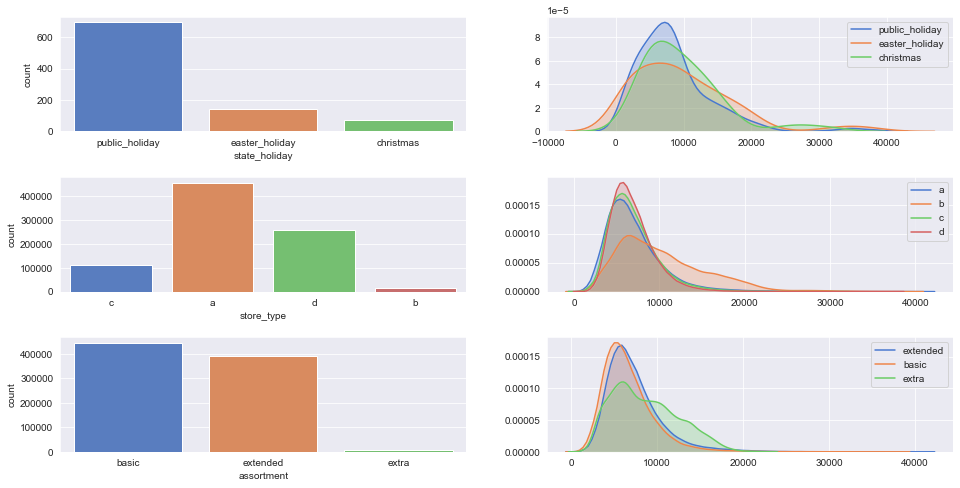

In [67]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# state_holiday
plt.subplot(3,2,1)
df_no_regular_day = df4[df4['state_holiday'] != 'regular_day']
sns.countplot(df_no_regular_day['state_holiday'])

plt.subplot(3,2,2)
sns.kdeplot(df4[df4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', shade=True)
sns.kdeplot(df4[df4['state_holiday'] == 'christmas']['sales'], label='christmas', shade=True)


# store_type
plt.subplot(3,2,3)
sns.countplot(df4['store_type'])

plt.subplot(3,2,4)
sns.kdeplot(df4[df4['store_type'] == 'a']['sales'], label='a', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'b']['sales'], label='b', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'c']['sales'], label='c', shade=True)
sns.kdeplot(df4[df4['store_type'] == 'd']['sales'], label='d', shade=True)

# assortment
plt.subplot(3,2,5)
sns.countplot(df4['assortment'])

plt.subplot(3,2,6)
sns.kdeplot(df4[df4['assortment'] == 'extended']['sales'], label='extended', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'basic']['sales'], label='basic', shade=True)
sns.kdeplot(df4[df4['assortment'] == 'extra']['sales'], label='extra', shade=True)

# adjusts vertical space between plots
plt.subplots_adjust(hspace = 0.4)

# display plots
plt.show()

## 4.2 Bivariate analysis

In [68]:
# checks the dataset
df4

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,basic,150.0,9,2006,0,1,2013,0,2013,1,1,1,2013-00,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,extra,860.0,10,1999,0,1,2013,0,2013,1,1,1,2013-00,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,extra,840.0,1,2013,1,48,2012,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,extra,1430.0,1,2013,0,1,2013,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


### H1. Stores with higher assortment should have higher sales.

In [69]:
# gets total sales for each 'assortment' type
df_total_sales_by_assortment = df4[['assortment','sales']].groupby('assortment').sum().reset_index()
df_total_sales_by_assortment

,assortment,sales
0,basic,2945750070
1,extended,2856484241
2,extra,70946312


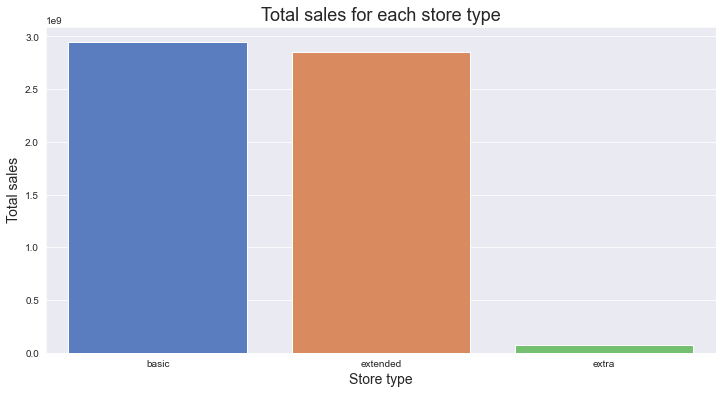

In [70]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(12, 6)

ax = sns.barplot(x='assortment', y='sales', data=df_total_sales_by_assortment)

# sets the title and axis labels
set_plots_features(ax, "Total sales for each store type", "Store type", "Total sales")

# displays the plot
plt.show()

We are assuming that stores that have higher assortment are classified as type `extra`. Thus, observing the barplot, we can verify that stores with **lesser assortment (`basic`) have higher sales**.

> #### In other words, **stores with higher assortment have lesser sales**.

However, we need to check if in the past, stores with higher assortment had higher sales.

In [71]:
# checks each assortment sales 
df_total_sales_by_year_week_assortment = df4[['year_week', 'assortment','sales']].groupby(['year_week','assortment']).sum().reset_index()
df_total_sales_by_year_week_assortment

,year_week,assortment,sales
0,2013-00,basic,13434262
1,2013-00,extended,12425669
2,2013-00,extra,269404
3,2013-01,basic,26007250
4,2013-01,extended,22917693
...,...,...,...
406,2015-29,extended,19570832
407,2015-29,extra,574020
408,2015-30,basic,23492454
409,2015-30,extended,23301780


In [72]:
# creates a pivot table
df_total_sales_pivot = df_total_sales_by_year_week_assortment.pivot(index='year_week', columns='assortment', values='sales')
df_total_sales_pivot

assortment,basic,extended,extra
year_week,,,
2013-00,13434262,12425669,269404
2013-01,26007250,22917693,350279
2013-02,17970974,16029584,377207
2013-03,24392076,21243431,404662
2013-04,19972891,18130077,363061
...,...,...,...
2015-26,27840342,27165959,684180
2015-27,20356210,20449036,586036
2015-28,25746704,25629698,632017


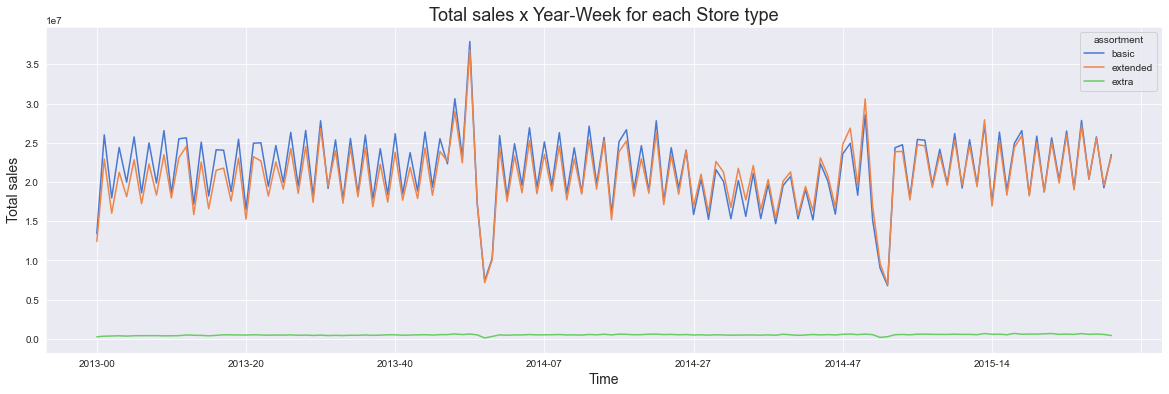

In [73]:
# plots a lineplot for 'aux3'
ax = df_total_sales_pivot.plot()

# sets the figure size in inches
ax.figure.set_size_inches(20, 6)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Year-Week for each Store type", "Time", "Total sales")

# displays the plot
plt.show()

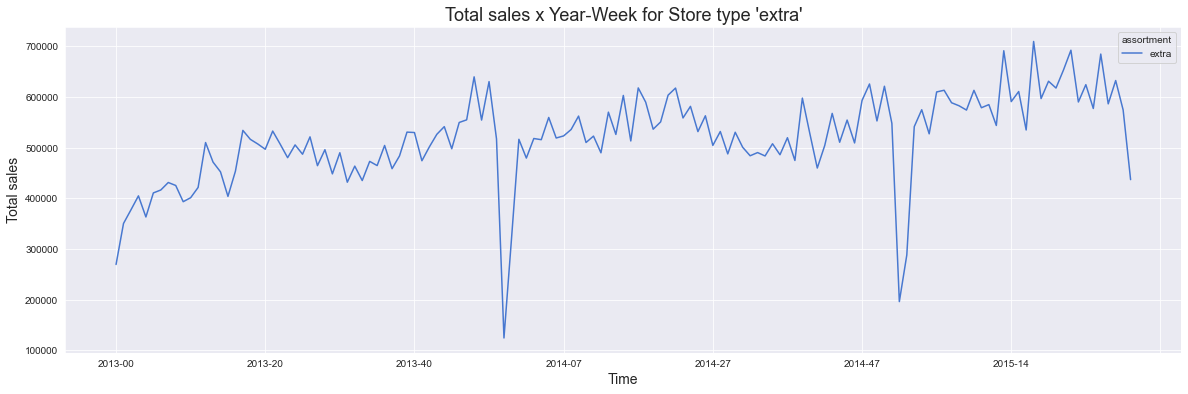

In [74]:
# filters for only 'extra' type of assortment
df_only_extra = df_total_sales_by_year_week_assortment[df_total_sales_by_year_week_assortment['assortment'] == 'extra']

# plots a lineplot for 'df_only_extra'
ax = df_only_extra.pivot(index='year_week', columns='assortment', values='sales').plot()

# sets the figure size in inches
ax.figure.set_size_inches(20, 6)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Year-Week for Store type 'extra'", "Time", "Total sales")

# displays the plot
plt.show()

Observing the line plots, we can verify that **stores with higher assortment (`extra`) have lesses sales**. 

> #### So, our hypothesis is **FALSE**.

In addition, as the variables have distinct behaviour, it may be interesting to **include them in our ML model**.

### H2. Stores with nearer competitors should have lesser sales.

In [75]:
# checks total sales for each 'competition_distance'
df_total_sales_by_competition_distance = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()
df_total_sales_by_competition_distance

,competition_distance,sales
0,20.0,4579807
1,30.0,17552666
2,40.0,29261626
3,50.0,60835848
4,60.0,22088359
...,...,...
650,46590.0,3554993
651,48330.0,3798660
652,58260.0,5718883
653,75860.0,6896821


In [76]:
# creates bins that range from 0 to 20000 with steps of 1000
bins = list (np.arange(0, 20000, 1000))

# places the data in the bins
df_total_sales_by_competition_distance['competition_distance_binned'] = pd.cut(df_total_sales_by_competition_distance['competition_distance'], bins=bins)

df_total_sales_by_competition_distance.sample(10)

,competition_distance,sales,competition_distance_binned
255,3200.0,7270804,"(3000, 4000]"
87,940.0,3597687,"(0, 1000]"
92,1000.0,9389130,"(0, 1000]"
112,1220.0,3456330,"(1000, 2000]"
519,13020.0,6160800,"(13000, 14000]"
258,3240.0,5036169,"(3000, 4000]"
111,1210.0,16927322,"(1000, 2000]"
424,7550.0,3443958,"(7000, 8000]"
581,18370.0,7275038,"(18000, 19000]"
69,710.0,19495195,"(0, 1000]"


In [77]:
# gets the total sales for each bin
df_competition_distance_binned = df_total_sales_by_competition_distance[['competition_distance_binned','sales']].groupby('competition_distance_binned').sum().reset_index()
df_competition_distance_binned

,competition_distance_binned,sales
0,"(0, 1000]",1832415839
1,"(1000, 2000]",918682669
2,"(2000, 3000]",610405362
3,"(3000, 4000]",378745560
4,"(4000, 5000]",325665741
5,"(5000, 6000]",218735915
6,"(6000, 7000]",168769215
7,"(7000, 8000]",133211838
8,"(8000, 9000]",180027950
9,"(9000, 10000]",121250715


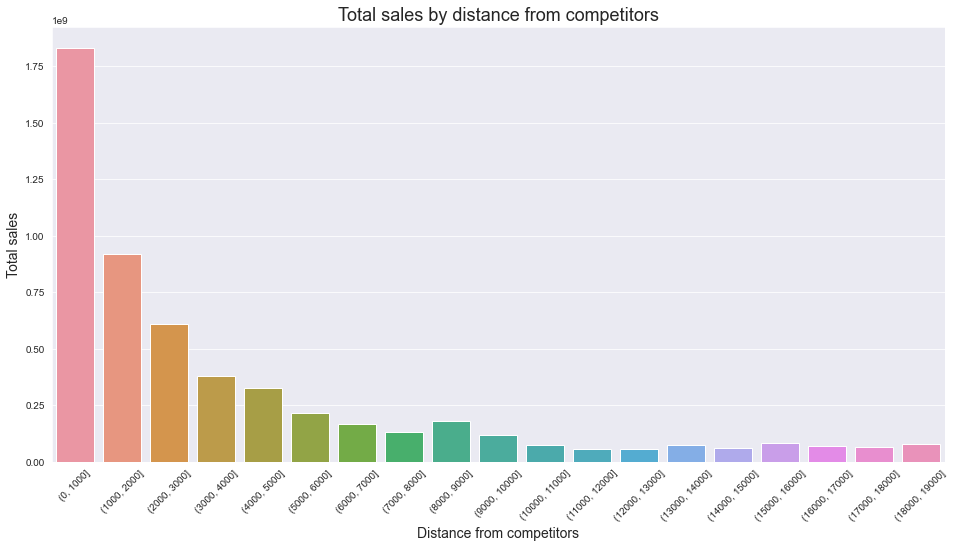

In [78]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot
ax = sns.barplot(x='competition_distance_binned', y='sales', data=df_competition_distance_binned)

# rotates xlabels
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)

# sets the title and axis labels
set_plots_features(ax, "Total sales by distance from competitors", "Distance from competitors", "Total sales")

# displays the plot
plt.show()

As we can observe from the bar plot, **stores with nearer competitors have higher sales**. 

> #### So, our hypothesis is **FALSE**.

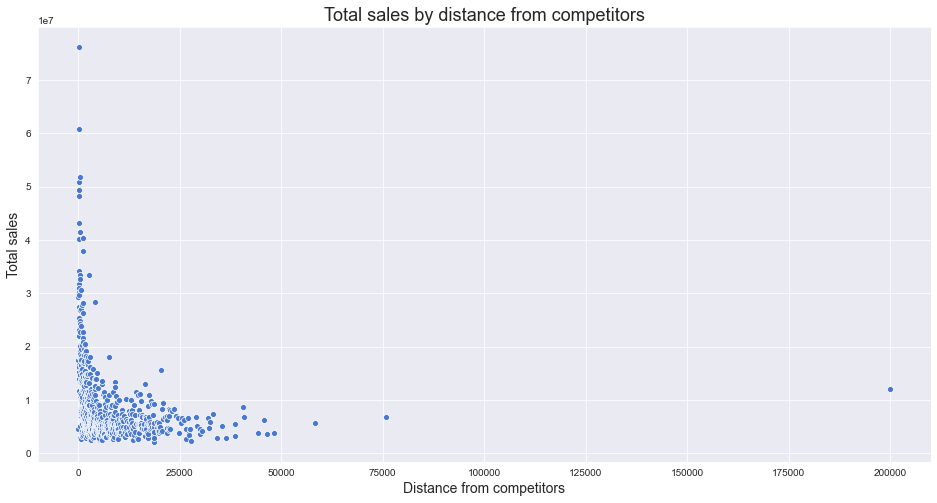

In [79]:
# checks total sales for each 'competition_distance'
df_total_sales_by_competition_distance = df4[['competition_distance','sales']].groupby('competition_distance').sum().reset_index()

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a scatter plot for sales in relation to competition_distance
ax = sns.scatterplot(x='competition_distance', y='sales', data=df_total_sales_by_competition_distance)

# sets the title and axis labels
set_plots_features(ax, "Total sales by distance from competitors", "Distance from competitors", "Total sales")

# displays the plot
plt.show()

We can observe from the scatter plot that we have a higher concentration of sales as we decrease the competition distance, which also makes our hypothesis **FALSE**.

#### Organizing the plots in a single grid

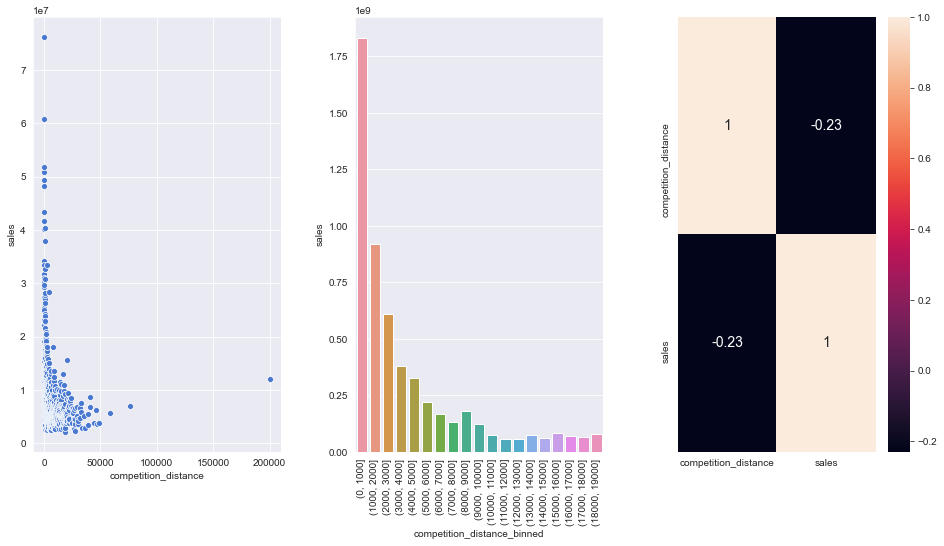

In [80]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a scatter plot
plt.subplot(1, 3, 1)
ax = sns.scatterplot(x='competition_distance', y='sales', data=df_total_sales_by_competition_distance)


# plots a bar plot
plt.subplot(1, 3, 2)
ax = sns.barplot(x='competition_distance_binned', y='sales', data=df_competition_distance_binned)

# rotates xlabels
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)


# plots a heatmap
plt.subplot(1, 3, 3)
sns.heatmap(df_total_sales_by_competition_distance.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# adjusts the width spaces between plots
plt.subplots_adjust(wspace = 0.3)

# displays the plots
plt.show()

**Correlations**

As observed in the results, the Pearson's correlation coefficient between `competition_distance` and `sales` is `-0.23` which tells us that is a **weak negative correlation**. Despite the weakness, we may include the `competition_distance` because it has a somewhat influence on the target variable (`sales`).

### H3. Stores with longer competitors should have higher sales.

We want to know how do our `sales` behave in relation to how long a competitor store has opened.

In [81]:
# gets all sales by months since the a competition store opened
df_total_sales_by_comp_time_month = df4[['competition_time_month','sales']].groupby('competition_time_month').sum().reset_index()

# gets only the 120 months AND opened in the same month of the sale
df_total_sales_120_months = df_total_sales_by_comp_time_month[(df_total_sales_by_comp_time_month['competition_time_month'] < 120) & (df_total_sales_by_comp_time_month['competition_time_month'] != 0)]

df_total_sales_120_months

,competition_time_month,sales
0,-32,198200
1,-31,993663
2,-30,2232685
3,-29,3175827
4,-28,4157527
...,...,...
147,115,15655375
148,116,15784105
149,117,15658505
150,118,14428150


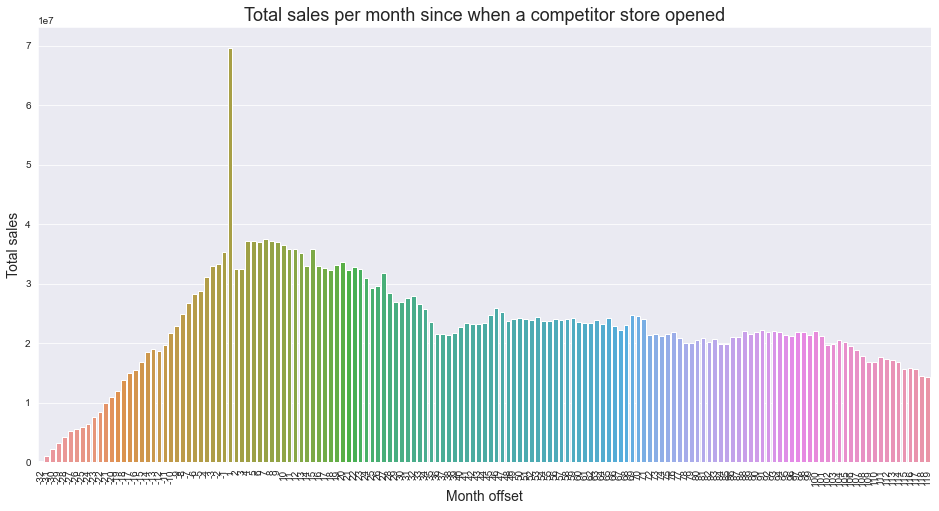

In [82]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot
ax = sns.barplot(x='competition_time_month', y='sales', data=df_total_sales_120_months)

# rotates the xticks
plt.xticks(rotation=90)

# sets the title and axis labels
set_plots_features(ax, "Total sales per month since when a competitor store opened", "Month offset", "Total sales")

# displays plot
plt.show()

- **Negative offset values:** we already started selling and we know when a competitor store will still open in x months. 
- **Positive offset values:** competitor store has already opened and we started selling.

As values gets near zero the higher are the sales. **The earlier the competition is, the higher the sales are.** 

> #### Thus, our hypothesis is **FALSE**.

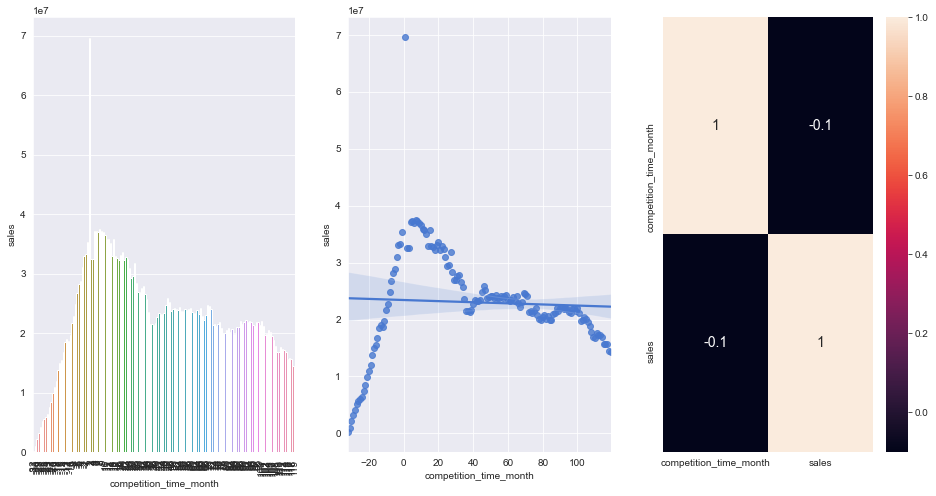

In [83]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot
plt.subplot(1, 3, 1)
sns.barplot(x='competition_time_month', y='sales', data=df_total_sales_120_months)

# rotates the xticks
plt.xticks(rotation=90)

# plots a regplot
plt.subplot(1, 3, 2)
sns.regplot(x='competition_time_month', y='sales', data=df_total_sales_120_months)

# plots a heatmap
plt.subplot(1, 3, 3)
sns.heatmap(df_total_sales_by_comp_time_month.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# displays the plot
plt.show()

**Correlations**

As observed in the results, the Pearson's correlation coefficient between `competition_time_month` and `sales` is `-0.1` which tells us that is a **super weak negative correlation**. Despite the weakness, we may include the `competition_time_month` because it has a somewhat influence on the target variable (`sales`). We'll check its relevance later in our project.

### H4. Stores with longer period of time in promotion should have higher sales.

In [84]:
# gets total sales based on how long a promotion was active
df_total_sales_by_promo_week = df4[['promo_time_week','sales']].groupby('promo_time_week').sum().reset_index()
df_total_sales_by_promo_week

,promo_time_week,sales
0,-126,80706
1,-125,147212
2,-124,107127
3,-123,140121
4,-122,116593
...,...,...
435,309,360433
436,310,277156
437,311,353546
438,312,268970


- `promotime_week > 0`: sales made inside the **extended** promotion time.
- `promotime_week < 0`: sale made inside the **regular** promotion time.

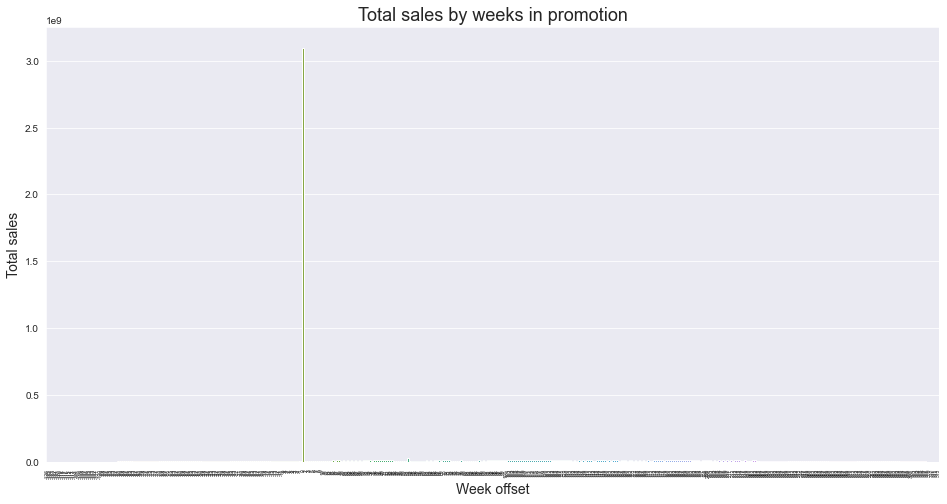

In [85]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot
ax = sns.barplot(x='promo_time_week', y='sales', data=df_total_sales_by_promo_week)

# rotates the xticks
plt.xticks(rotation=90, fontsize=5)

# sets the title and axis labels
set_plots_features(ax, "Total sales by weeks in promotion", "Week offset", "Total sales")

# displays the plot
plt.show()

As we observe in the bar plot, we can't see anything because there are loads of data. So, let's divide our data in two periods: **regular promotion and extended promotion**.

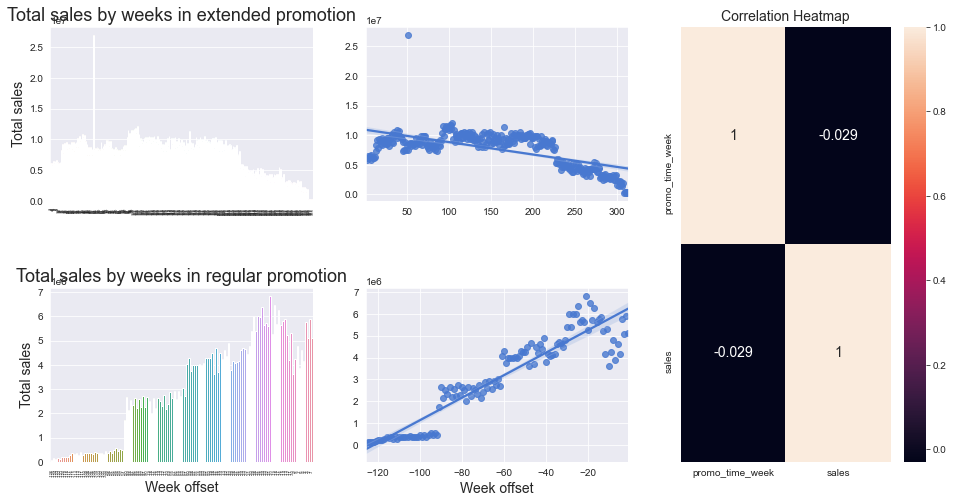

In [86]:
from matplotlib.gridspec import GridSpec

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

grid = GridSpec(2, 3)

# adjusts the space between subplots
plt.subplots_adjust(hspace = 0.5)

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# gets the extended promo data
df_total_sales_extended_promo = df_total_sales_by_promo_week[df_total_sales_by_promo_week['promo_time_week'] > 0] 

# plots a barplot
plt.subplot(grid[0, 0])
ax1 = sns.barplot(x='promo_time_week', y='sales', data=df_total_sales_extended_promo);

# sets the title and axis labels
set_plots_features(ax1, "Total sales by weeks in extended promotion", " ", "Total sales")

# rotates the xticks
plt.xticks(rotation=90, fontsize=4)

# plots a regplot
plt.subplot(grid[0, 1])
ax2 = sns.regplot(x='promo_time_week', y='sales', data=df_total_sales_extended_promo);

# sets the title and axis labels
set_plots_features(ax2, " ", " ", " ")


# gets the regular promo data
df_total_sales_regular_promo = df_total_sales_by_promo_week[df_total_sales_by_promo_week['promo_time_week'] < 0]

# plots a barplot
plt.subplot(grid[1, 0])
ax3 = sns.barplot(x='promo_time_week', y='sales', data=df_total_sales_regular_promo);

# sets the title and axis labels
set_plots_features(ax3, "Total sales by weeks in regular promotion", "Week offset", "Total sales")

# rotates the xticks
plt.xticks(rotation=90, fontsize=4)


# plots a regplot
plt.subplot(grid[1, 1])
ax4 = sns.regplot(x='promo_time_week', y='sales', data=df_total_sales_regular_promo);

# sets the title and axis labels
set_plots_features(ax4, " ", "Week offset", " ")


# plots correlation heatmap
plt.subplot(grid[:,2])
ax5 = sns.heatmap(df_total_sales_by_promo_week.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# sets the title
ax5.set_title("Correlation Heatmap", fontsize=14)


# displays the plot
plt.show()

As we can observe in the **Total sales x Weeks in extended promotion**, there's a period in which the extended promotion results in more sales, then after a period of time, the total sales starts to drecrease.

From the **Total sales x Weeks in regular promotion**, we can observe that as the offset gets more and more near zero, the sales starts to increase.

Thus, **stores with longer period of time in promotion don't have higher sales.**, because the sales start to drecrease as the promotion gets longer. 

> #### Thus, our hypothesis is **FALSE**.

**Correlations**

In addition, from the **Correlation Heatmap** we got a coefficient of `-0.029` which is pretty close to `zero`. Thus, we have a **super weak correlation**, which makes sense because looking at our data, we have long periods of almost constant total sales (see  **Total sales x Weeks in extended promotion**).

So, maybe we won't include `promo_time_week` in the model. Of course, this variable might work if we combine it with another variable, but we'll leave it for the time being.

### H5. Stores with longer period of time in promotion should have higher sales.

As this hypothesis is similar to H4. We'll leave to validate it in the next CRISP cycle.

### H6. Stores with higher consecutive promotions should have higher sales.

In [87]:
# gets total sales made based on promotion and consecutive promotions
df4[['promo','promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


Observing the results, there were more sales when there was only a promotion (`promo = 1` AND `promo2 = 0`) than when there were consecutive promotions (`promo = 1` AND `promo2 = 1`).

In [88]:
# gets all rows in which there were consecutive promotions
df_consecutive_promotion_sales = df4[(df4['promo'] == 1) & (df4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
df_consecutive_promotion_sales

,year_week,sales
0,2013-01,20995409
1,2013-03,19481514
2,2013-05,20580811
3,2013-07,20273185
4,2013-09,21451952
...,...,...
67,2015-22,21069133
68,2015-24,22839486
69,2015-26,23972605
70,2015-28,21867757


In [89]:
# gets all rows in which there weren't consecutive promotions
df_no_consecutive_promotion_sales = df4[(df4['promo'] == 1) & (df4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
df_no_consecutive_promotion_sales

,year_week,sales
0,2013-01,22118270
1,2013-03,20567037
2,2013-05,22087889
3,2013-07,21631750
4,2013-09,22727171
...,...,...
67,2015-22,23590590
68,2015-24,23635449
69,2015-26,25394352
70,2015-28,23393262


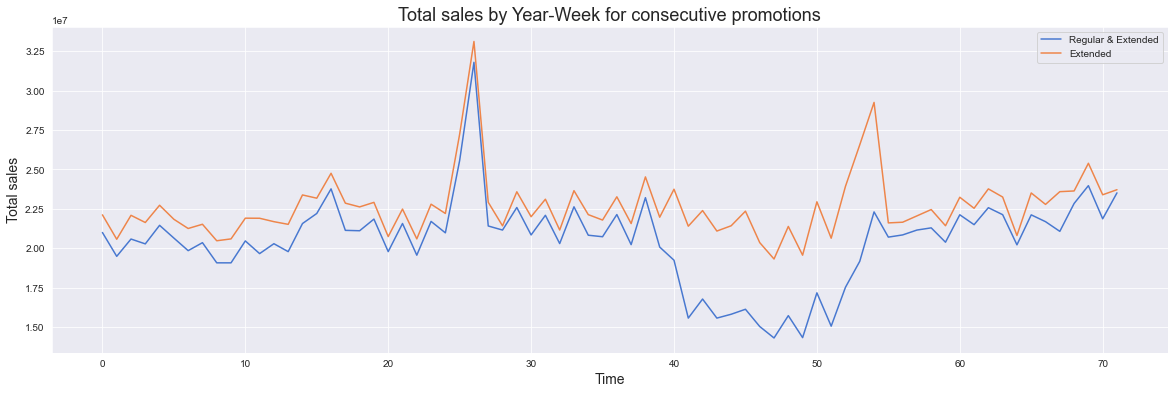

In [90]:
# plots a lineplot
ax = df_consecutive_promotion_sales.plot()

# plots in the same grid
df_no_consecutive_promotion_sales.plot(ax = ax)

# sets the figure size in inches
ax.figure.set_size_inches(20, 6)

# sets the title and axis labels
set_plots_features(ax, "Total sales by Year-Week for consecutive promotions", "Time", "Total sales")

# sets the legend
ax.legend(labels=['Regular & Extended', 'Extended'])

# displays the plot
plt.show()

Observing the results it seems that **stores with higher consecutive promotions don't have higher sales**. 

> #### Thus, our hypothesis is **FALSE**.

**Relevance**

Thinking about the relevance of the variable `promo2` to the ML model, we can say that its relevance is low. Despite the particular decrease in sales during a period, we still need a second opinion that will come from an algorithm that will aid us to decide whether we include `promo2` or not.

### H7. Stores that open on Xmas should have higher sales. 

In [91]:
# gets only the holidays excluding the regular days
df_holidays_only = df4[df4['state_holiday'] != 'regular_day']

# getting the total sales by state holiday
df_total_sales_by_state_holiday = df_holidays_only[['state_holiday','sales']].groupby('state_holiday').sum().reset_index()
df_total_sales_by_state_holiday

,state_holiday,sales
0,christmas,691806
1,easter_holiday,1433744
2,public_holiday,5890305


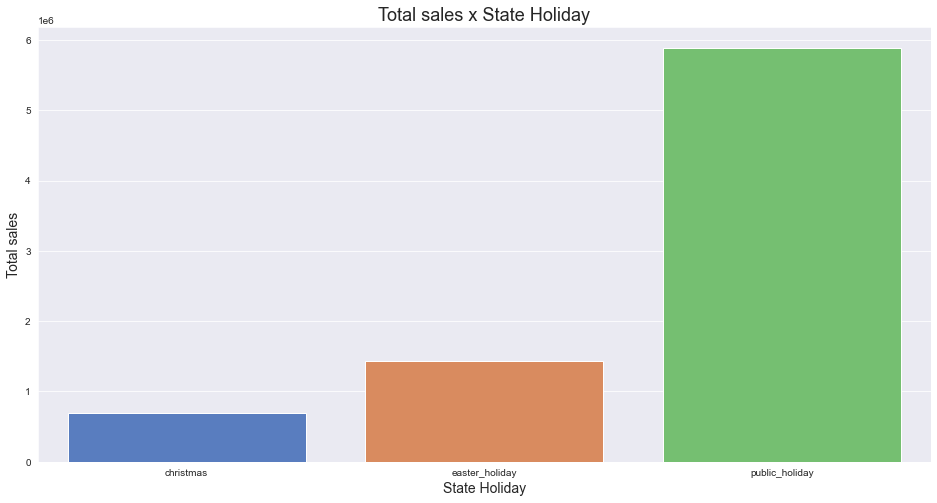

In [92]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by state holiday
sns.barplot(x='state_holiday', y='sales', data=df_total_sales_by_state_holiday)

# sets the title and axis labels
set_plots_features(ax, "Total sales x State Holiday", "State Holiday", "Total sales")

# displays the plot
plt.show()

In [93]:
# gets total sales by year by state holiday
df_total_sales_by_year_by_sate_holiday = df_holidays_only[['year','state_holiday', 'sales']].groupby(['year','state_holiday']).sum().reset_index()
df_total_sales_by_year_by_sate_holiday

,year,state_holiday,sales
0,2013,christmas,331182
1,2013,easter_holiday,454997
2,2013,public_holiday,2052408
3,2014,christmas,360624
4,2014,easter_holiday,463353
5,2014,public_holiday,2084616
6,2015,easter_holiday,515394
7,2015,public_holiday,1753281


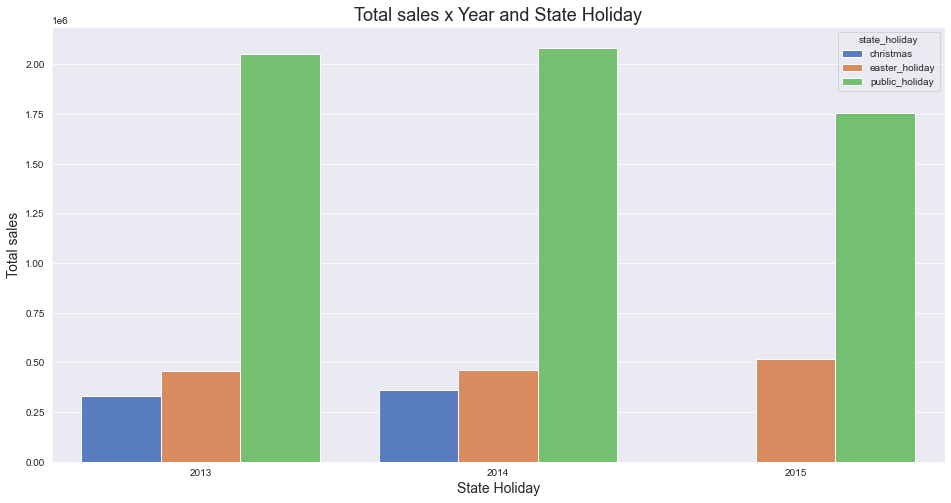

In [94]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by state holiday
sns.barplot(x='year', y='sales', hue='state_holiday', data=df_total_sales_by_year_by_sate_holiday)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Year and State Holiday", "State Holiday", "Total sales")

# displays the plot
plt.show()

As observed in the previous results, **stores that open on Xmas don't have higher sales**. 

> #### Thus, our hypothesis is **FALSE**.

One observation that we need to make here is that on year 2015, we still don't have the data from Xmas sales, because the data ends on July 31st, 2015.

In addition, as we have changes in `sales` depending on the type of `state_holiday` and which `year` is, we can consider these variables in our ML model.

### H8. Stores should have higher sales along the years.

In [95]:
# gets the total sales by year
df_total_sales_by_year = df4[['year', 'sales']].groupby('year').sum().reset_index()
df_total_sales_by_year

,year,sales
0,2013,2302876084
1,2014,2180804896
2,2015,1389499643


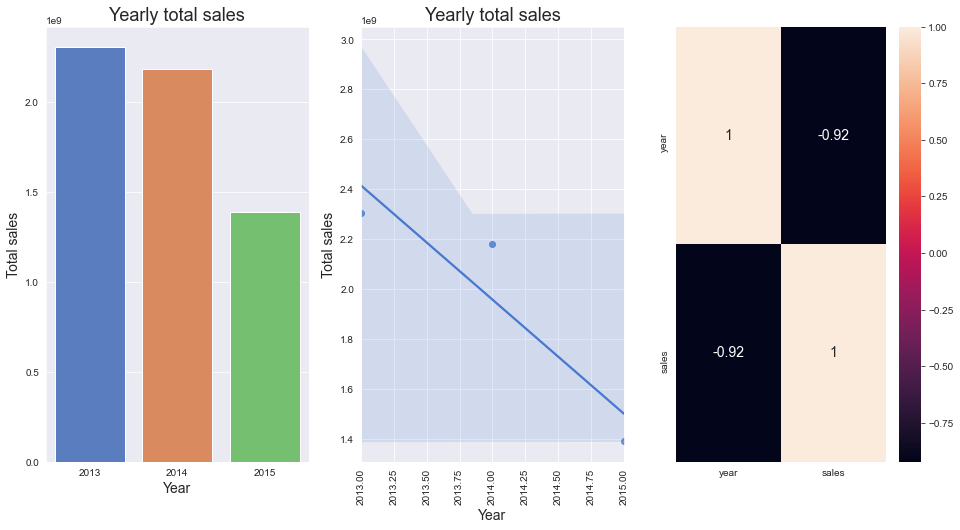

In [96]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by year
plt.subplot(1, 3, 1)
ax = sns.barplot(x='year', y='sales', data=df_total_sales_by_year)

# sets the title and axis labels
set_plots_features(ax, "Yearly total sales", "Year", "Total sales")


# plots a barplot for total sales by year
plt.subplot(1, 3, 2)
ax = sns.regplot(x='year', y='sales', data=df_total_sales_by_year)

# sets the title and axis labels
set_plots_features(ax, "Yearly total sales", "Year", "Total sales")

# rotates xticks labels
plt.xticks(rotation=90)


# plots a heatmap
plt.subplot(1, 3, 3)
sns.heatmap(df_total_sales_by_year.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# displays the plot
plt.show()

As observed in the previous results, stores **don't have higher sales along the years**. In addition, by observing the Pearson correlation coefficient of `-0.92`, we can verify that there is a **strong negative correlation** between `year` and `sales`. Thus, our hypothesis is **FALSE**.

### H9. Stores should have higher sales on the second semester of the year.

In [97]:
# gets the total sales by month
df_total_sales_by_month = df4[['month', 'sales']].groupby('month').sum().reset_index()
df_total_sales_by_month

,month,sales
0,1,566728724
1,2,528734410
2,3,599831906
3,4,575895295
4,5,569248217
5,6,578112775
6,7,595059205
7,8,361791202
8,9,342570131
9,10,351878728


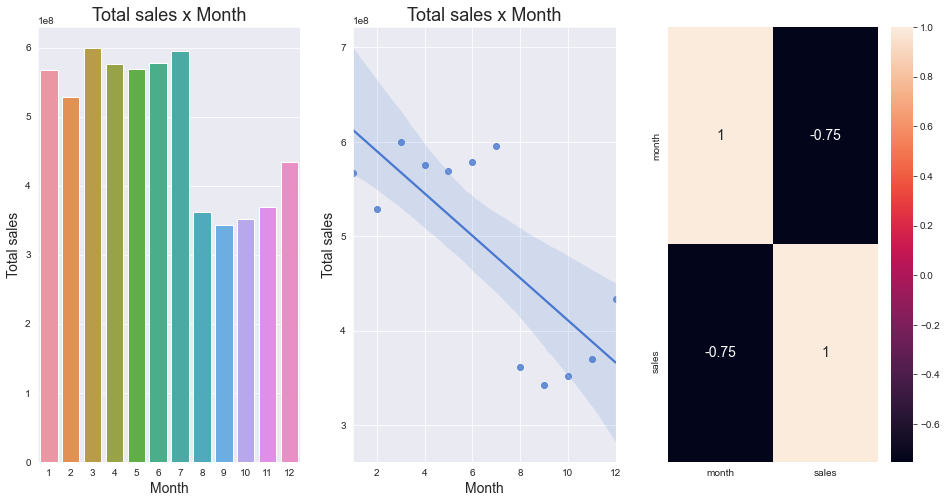

In [98]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by month
plt.subplot(1, 3, 1)
ax = sns.barplot(x='month', y='sales', data=df_total_sales_by_month)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Month", "Month", "Total sales")


# plots a barplot for total sales by month
plt.subplot(1, 3, 2)
ax = sns.regplot(x='month', y='sales', data=df_total_sales_by_month)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Month", "Month", "Total sales")


# plots a barplot for total sales by month
plt.subplot(1, 3, 3)
sns.heatmap(df_total_sales_by_month.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# displays the plots
plt.show()

As observed in the previous results, stores **don't have higher sales on the second semester of the year**. In addition, by observing the Pearson correlation coefficient of `-0.75`, we can verify that there is a **strong negative correlation** between `month` and `sales`. 

> #### Thus, our hypothesis is **FALSE**.

### H10. Stores should have higher sales after the 10th day of the month.

In [99]:
# gets the total sales by before and after the 10th day of the month
df_total_sales_by_day = df4[['day', 'sales']].groupby('day').sum().reset_index()

df_total_sales_by_day

,day,sales
0,1,155983560
1,2,233513169
2,3,194582812
3,4,228301010
4,5,212869176
5,6,197094539
6,7,201380487
7,8,189718770
8,9,175922427
9,10,181039363


In [100]:
# classifies which day is before and after the 10th day of the month
df4['before_after'] = df4['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')

# gets the total sales by before and after the 10th day of the month
df_total_sales_by_before_after = df4[['before_after', 'sales']].groupby('before_after').sum().reset_index()

df_total_sales_by_before_after

,before_after,sales
0,after_10_days,3902775310
1,before_10_days,1970405313


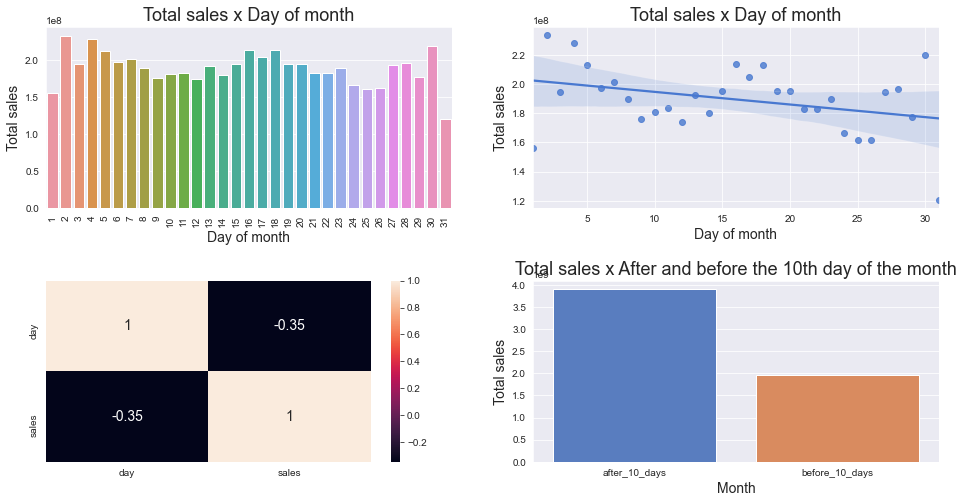

In [101]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by day
plt.subplot(2, 2, 1)
ax = sns.barplot(x='day', y='sales', data=df_total_sales_by_day)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Day of month", "Day of month", "Total sales")

# rotates the xticks
plt.xticks(rotation=90)

# plots a barplot for total sales by day
plt.subplot(2, 2, 2)
ax = sns.regplot(x='day', y='sales', data=df_total_sales_by_day)

# sets the title and axis labels
set_plots_features(ax, "Total sales x Day of month", "Day of month", "Total sales")


# plots a barplot for total sales by day
plt.subplot(2, 2, 3)
sns.heatmap(df_total_sales_by_day.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})


# plots a barplot for total sales by before and after the 10th day of the month
plt.subplot(2, 2, 4)
ax = sns.barplot(x='before_after', y='sales', data=df_total_sales_by_before_after)

# sets the title and axis labels
set_plots_features(ax, "Total sales x After and before the 10th day of the month", "Month", "Total sales")

# adjusts the vertical space between plots
plt.subplots_adjust(hspace = 0.4)

# displays the plots
plt.show()

As observed in the previous results, stores **have higher sales after the 10th day of the month**. 

> #### Thus, our hypothesis is **TRUE**.

**Correlation**

In addition, checking the Pearson's correlation coefficient, we got a value of `-0.35` which tells us that is a **no so strong correlation** between `day` and `sales`. However, as we have different values for total sales before and after the 10th day of the month, this variable **can be relevant for our ML Model**.

### H11. Stores should have lesser sales on weekends.

In [102]:
# gets the total sales by day_of_week
df_total_sales_by_day_of_week = df4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()
df_total_sales_by_day_of_week

,day_of_week,sales
0,1,1130203012
1,2,1020411930
2,3,954962863
3,4,911177709
4,5,980555941
5,6,846317735
6,7,29551433


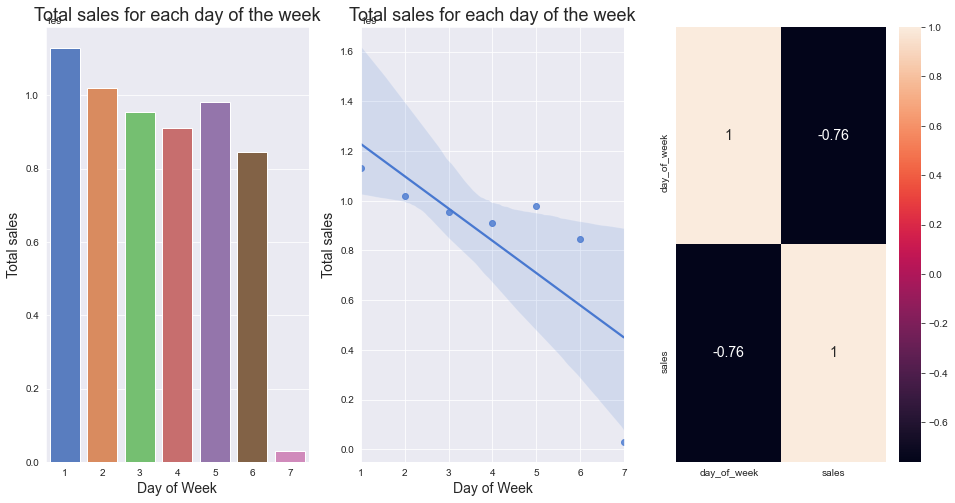

In [103]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by day_of_week
plt.subplot(1, 3, 1)
ax = sns.barplot(x='day_of_week', y='sales', data=df_total_sales_by_day_of_week)

# sets the title and axis labels
set_plots_features(ax, "Total sales for each day of the week", "Day of Week", "Total sales")


# plots a barplot for total sales by day_of_week
plt.subplot(1, 3, 2)
ax = sns.regplot(x='day_of_week', y='sales', data=df_total_sales_by_day_of_week)

# sets the title and axis labels
set_plots_features(ax, "Total sales for each day of the week", "Day of Week", "Total sales")

# plots a barplot for total sales by day_of_week
plt.subplot(1, 3, 3)
sns.heatmap(df_total_sales_by_day_of_week.corr(method='pearson'), annot=True, annot_kws={"fontsize":14})

# displays the plots
plt.show()

**Correlation**

As observed in the previous results, stores **have lesser sales on weekends**. In addition, by observing the Pearson correlation coefficient of `-0.75`, we can verify that there is a **strong negative correlation** between `day_of_week` and `sales`. 

> #### Thus, our hypothesis is **TRUE**.

### H12. Stores should have lesser sales during school holidays.

In [104]:
# gets the total sales by school_holiday
df_total_sales_by_school_holiday = df4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
df_total_sales_by_school_holiday

,school_holiday,sales
0,0,4696260531
1,1,1176920092


In [105]:
# gets the total sales by month and school_holiday
df_total_sales_by_month_school_holiday = df4[['month', 'school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()
df_total_sales_by_month_school_holiday

,month,school_holiday,sales
0,1,0,490739687
1,1,1,75989037
2,2,0,476170426
3,2,1,52563984
4,3,0,529719808
5,3,1,70112098
6,4,0,432131835
7,4,1,143763460
8,5,0,523512599
9,5,1,45735618


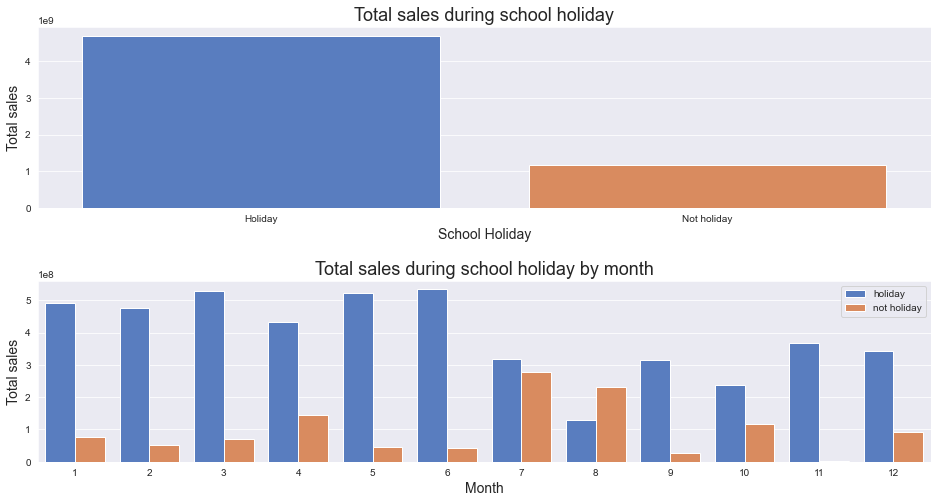

In [106]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a barplot for total sales by school_holiday
plt.subplot(2, 1, 1)
ax = sns.barplot(x='school_holiday', y='sales', data=df_total_sales_by_school_holiday)

# sets the title and axis labels
set_plots_features(ax, "Total sales during school holiday", "School Holiday", "Total sales")

# sets xticks labels
ax.set_xticklabels(['Holiday','Not holiday'])

# plots a barplot for total sales by month and school_holiday
plt.subplot(2, 1, 2)
ax = sns.barplot(x='month', y='sales', hue='school_holiday', data=df_total_sales_by_month_school_holiday)

# sets the title and axis labels
set_plots_features(ax, "Total sales during school holiday by month", "Month", "Total sales")

# sets legend
labels = ['holiday','not holiday']
h, _ = ax.get_legend_handles_labels()
ax.legend(h, labels)

# adjusts the vertical space between plots
plt.subplots_adjust(hspace = 0.4)

# displays the plots
plt.show()

As observed in the previous results, in general, stores **have lesser sales during school holidays, except on months of July and August**. 

> #### Thus, our hypothesis is **TRUE**.

### 4.2.1. Hypotheses summary

In [107]:
from tabulate import tabulate

In [108]:
tab = [
    ['Hypothesis','Conclusion','Relavance to ML model'],
    ['H1','False','Low'],
    ['H2','False','Medium'],
    ['H3','False','Medium'],
    ['H4','False','Low'],
    ['H5','--','--'],
    ['H6','False','Low'],
    ['H7','False','Medium'],
    ['H8','False','High'],
    ['H9','False','High'],
    ['H10','True','High'],
    ['H11','True','High'],
    ['H12','True','Low']
]

print(tabulate(tab, headers='firstrow'))

Hypothesis    Conclusion    Relavance to ML model
------------  ------------  -----------------------
H1            False         Low
H2            False         Medium
H3            False         Medium
H4            False         Low
H5            --            --
H6            False         Low
H7            False         Medium
H8            False         High
H9            False         High
H10           True          High
H11           True          High
H12           True          Low


## 4.3 Multivariate analysis

### 4.3.1 Numerical Attributes

In [109]:
# checks the numerical attributes dataset
num_attributes.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


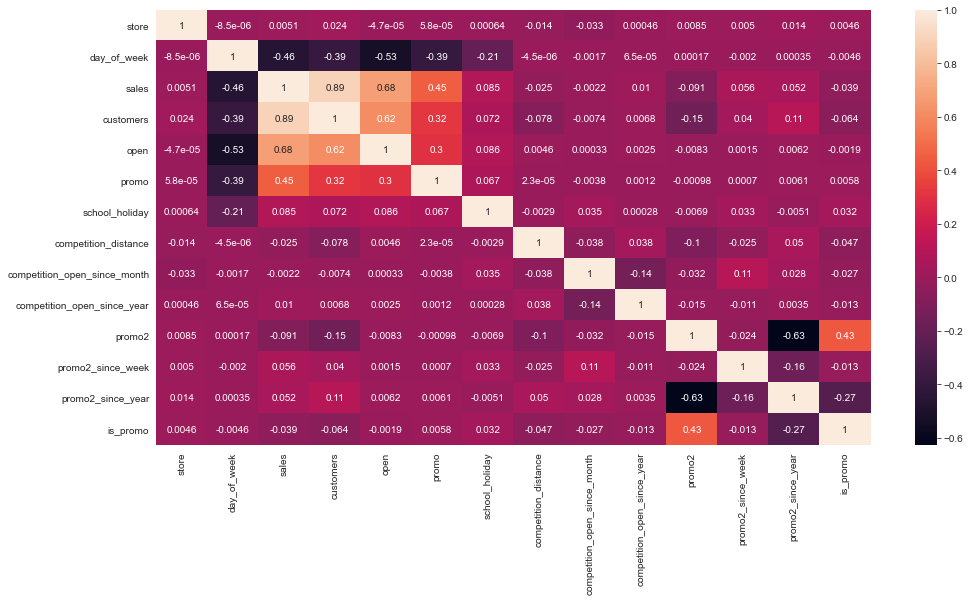

In [110]:
# gets the correlation between the numerical variables
correlation = num_attributes.corr(method='pearson')

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots the heatmap
sns.heatmap(correlation, annot=True)

# displays the plot
plt.show()

### 4.3.2 Categorical Attributes
To make the correlation between two categorical variables, we'll use the [Cramér V method](https://en.wikipedia.org/wiki/Cram%C3%A9r%27s_V).

In [121]:
# gets the categorical variables from the dataset
df_cat_vars = df4.select_dtypes(include='object')
df_cat_vars.head()

,state_holiday,store_type,assortment,year_week,before_after
0,regular_day,c,basic,2015-30,after_10_days
1,regular_day,a,basic,2015-30,after_10_days
2,regular_day,a,basic,2015-30,after_10_days
3,regular_day,c,extended,2015-30,after_10_days
4,regular_day,a,basic,2015-30,after_10_days


In [122]:
# builds the contigency matrix (or confusion matrix) 
confusion_matrix = pd.crosstab(df_cat_vars['state_holiday'], df_cat_vars['store_type']).values
confusion_matrix

array([[     4,     66,      0,      1],
       [    36,    100,      0,      9],
       [   236,    285,     65,    108],
       [456766,  15109, 112903, 258650]])

#### 4.3.2.1 Manually calculating Cramér V using [scipy.stats.chi2_contingency](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.chi2_contingency.html)

In [123]:
from scipy.stats import chi2_contingency

In [124]:
# getting the chi-squared
chi2 = chi2_contingency(confusion_matrix)[0]
chi2

12792.159524019908

In [125]:
# getting the sum of all values in the matrix
n = confusion_matrix.sum()
n

844338

In [126]:
# getting the rows, cols
r, k = confusion_matrix.shape

print(r, k)

4 4


From [wikipedia](https://en.wikipedia.org/wiki/Cram%C3%A9r's_V).

Cramér's V is computed by taking the square root of the chi-squared statistic divided by the sample size and the minimum dimension minus 1:

### $V = \sqrt{\frac{\varphi^2}{\min(k - 1,r-1)}} = \sqrt{ \frac{\chi^2/n}{\min(k - 1,r-1)}}$

where:
* $\varphi$ is the phi coefficient.
* $\chi^2$ is derived from Pearson's chi-squared test
* $n$ is the grand total of observations and
* $k$ being  the number of columns.
* $r$ being  the number of rows.

**Bias correction**

Cramér's V can be a heavily biased estimator of its population counterpart and will tend to overestimate the strength of association. A bias correction, using the above notation, is given by:

$\tilde V = \sqrt{\frac{\tilde\varphi^2}{\min(\tilde k - 1,\tilde r - 1)}} $&nbsp;

where

$ \tilde\varphi^2 = \max\left(0,\varphi^2 - \frac{(k-1)(r-1)}{n-1}\right) $&nbsp;

and

$ \tilde k = k - \frac{(k-1)^2}{n-1} $&nbsp;

$ \tilde r = r - \frac{(r-1)^2}{n-1} $&nbsp;

Then $\tilde V$ estimates the same population quantity as Cramér's V but with typically much smaller mean squared error. The rationale for the correction is that under independence, $E[\varphi^2]=\frac{(k-1)(r-1)}{n-1}$.

The range of Cramér V is [0 to 1], so we don't have negative correlation. Thus, the closer to zero, the lesser is the correlation and the closer to 1, the higher is the correlation.

In [127]:
# calculates Cramér V
cramer_v = np.sqrt((chi2/n) / min(k-1, r-1))
cramer_v

0.07106457093267678

#### 4.3.2.2 Using the defined `cramer_v` function to make the calculations

In [130]:
# makes all the possible combinations between categorical variables
a1 = cramer_v(df_cat_vars['state_holiday'], df_cat_vars['state_holiday'])
a2 = cramer_v(df_cat_vars['state_holiday'], df_cat_vars['store_type'])
a3 = cramer_v(df_cat_vars['state_holiday'], df_cat_vars['assortment'])

a4 = cramer_v(df_cat_vars['store_type'], df_cat_vars['state_holiday'])
a5 = cramer_v(df_cat_vars['store_type'], df_cat_vars['store_type'])
a6 = cramer_v(df_cat_vars['store_type'], df_cat_vars['assortment'])

a7 = cramer_v(df_cat_vars['assortment'], df_cat_vars['state_holiday'])
a8 = cramer_v(df_cat_vars['assortment'], df_cat_vars['store_type'])
a9 = cramer_v(df_cat_vars['assortment'], df_cat_vars['assortment'])

# builds the dataset to make the correlations
d = pd.DataFrame({'state_holiday': [a1, a2, a3],
              'store_type': [a4, a5, a6],
              'assortment': [a7, a8, a9],
             })

# sets index equal to columns
d = d.set_index(d.columns)
d

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


#### 4.3.2.3 Plotting the correlations

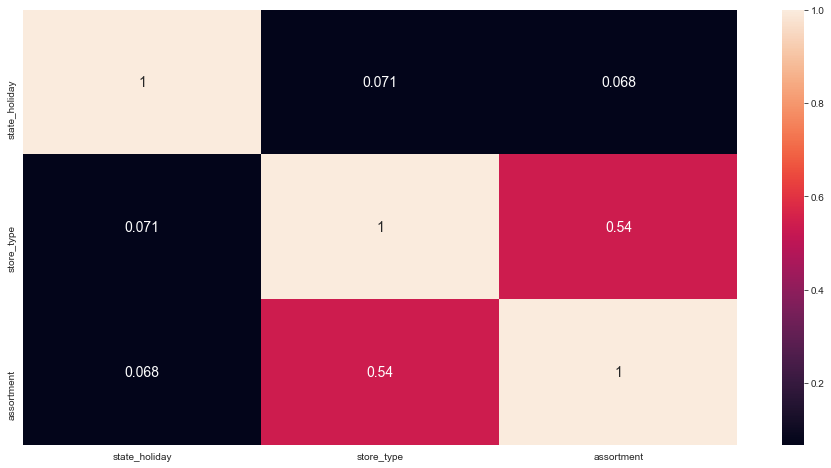

In [131]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots the heatmap
sns.heatmap(d, annot=True, annot_kws={"fontsize":14})

# displays plot
plt.show()

As observed in the results, the correlation coefficient between `store_type` and `assortment` is `0.54` which is a medium correlation and makes sense, as the bigger the store, the higher is the assortment of its products.

# 5.0 DATA PREPARATION

### 5.0.1 Project Checkpoint
Let's save our progress and make a checkpoint in our project by making a copy of `df4`. So we don't have to run everything from the start. We can start from here.

In [134]:
# copies df4 to df5
df5 = df4.copy()

In [135]:
# checks de dataset
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,before_after
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,9,2008,0,31,2015,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0,after_10_days
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,11,2007,1,13,2010,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279,after_10_days
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,12,2006,1,14,2011,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226,after_10_days
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,9,2009,0,31,2015,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0,after_10_days
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,4,2015,0,31,2015,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0,after_10_days


## 5.1 Normalization

We need to check the variables distributions. So, we check the distributions from section **4.1.2 Numerical variable**.

![](img/412_numerical_variables_hist.png)

As we can observe, there is no variable presenting a normal distribution, note even nearly normal. So, it is preferred to leave as it is than to risk a errorneous normalization.

## 5.2 Rescaling

First we need to identify which variable we need to apply the rescaling.

In [136]:
# selects only numerical data types variables
df_numerical_vars = df5.select_dtypes(include=['int64','float64'])
df_numerical_vars.head()

,store,day_of_week,sales,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,1,1,1270.0,9,2008,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,1,1,570.0,11,2007,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,1,1,14130.0,12,2006,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1,1,620.0,9,2009,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,1,1,29910.0,4,2015,0,31,2015,0,2015,7,31,31,4,0


#### Using sklearn.preprocessing.RobustScaler
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.RobustScaler.html?highlight=robustscaler#sklearn.preprocessing.RobustScaler

#### Using sklearn.preprocessing.MinMaxScaler
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html?highlight=sklearn%20preprocessing%20minmaxscaler

In [145]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler

In [146]:
# instantiates the classes
rs = RobustScaler()
mms = MinMaxScaler()

### 5.2.1 Rescaling `competition_distance`

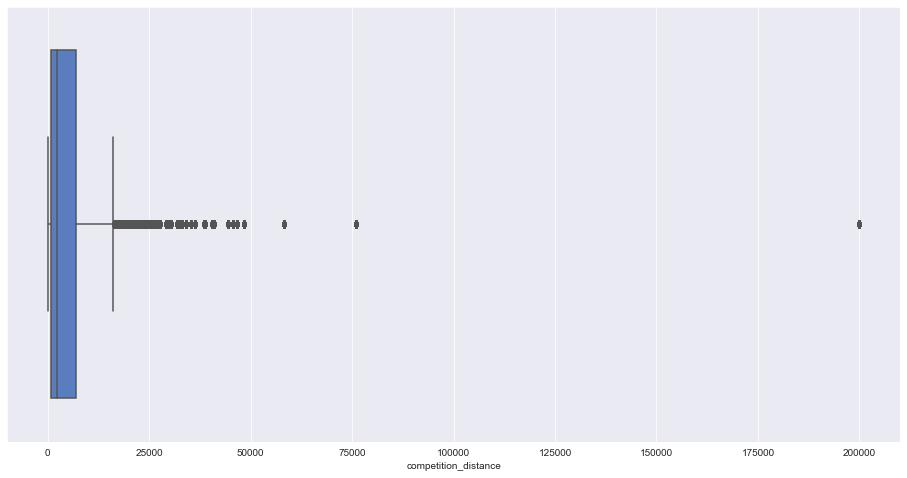

In [139]:
# checks for outliers

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a box plot
ax = sns.boxplot(df5['competition_distance'])

# display the plot
plt.show()

As observed in the results, there is a clear presence of outliers.

In [147]:
# competition_distance
df5['competition_distance'] = rs.fit_transform(df5[['competition_distance']])

### 5.2.2 Rescaling `competition_time_month`

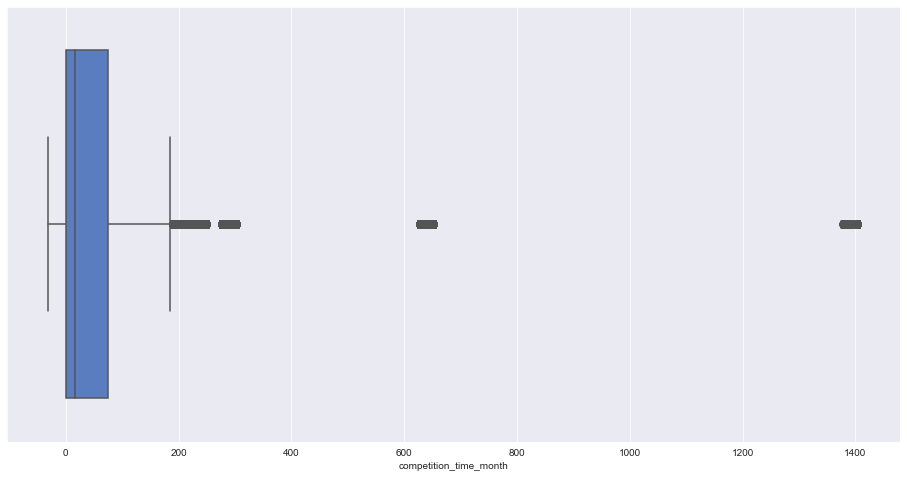

In [143]:
# checks for outliers

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a box plot
ax = sns.boxplot(df5['competition_time_month'])

# display the plot
plt.show()

As observed in the results, there is a clear presence of outliers.

In [148]:
# competition_time_month
df5['competition_time_month'] = rs.fit_transform(df5[['competition_time_month']])

### 5.2.3 Rescaling `promo_time_week`

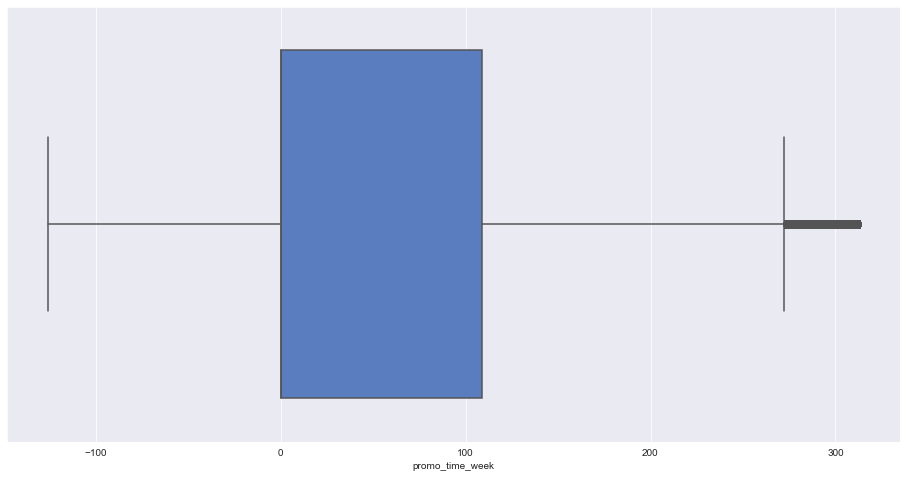

In [144]:
# checks for outliers

# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a box plot
ax = sns.boxplot(df5['promo_time_week'])

# display the plot
plt.show()

As observed in the results, there is a clear presence of outliers. However, they are no that far from the superior whisker. So we can take a chance to use the Min-Max Scaler.

In [149]:
# promo_time_week
df5['promo_time_week'] = mms.fit_transform(df5[['promo_time_week']])

In [150]:
# year
df5['year'] = mms.fit_transform(df5[['year']])

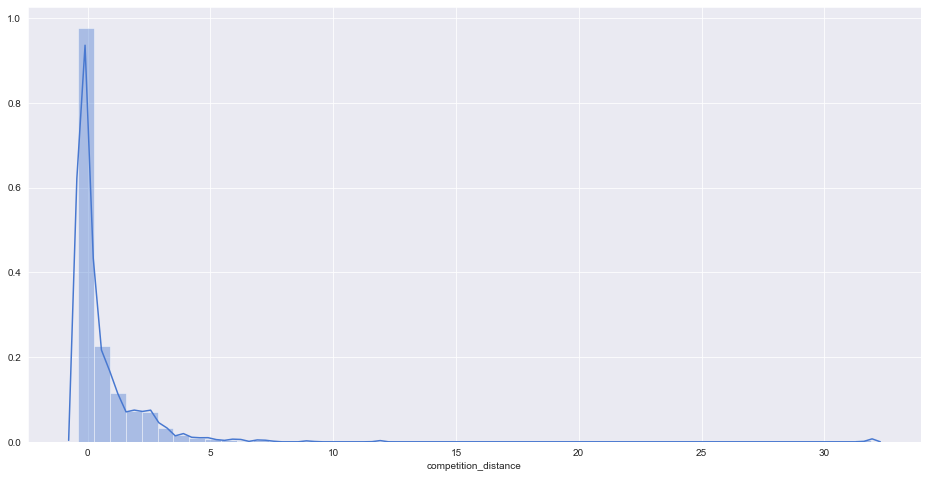

In [151]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a box plot
ax = sns.distplot(df5['competition_distance'])

# display the plot
plt.show()

## 5.3 Transformation

### 5.3.1 Encoding

#### 5.3.1.1 One Hot Encoding for `state_holiday`

In [152]:
# check the dataset
df5.head()

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,before_after
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,after_10_days
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,after_10_days
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,after_10_days
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,after_10_days
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,after_10_days


In [153]:
# state_holiday
# One Hot Encoding
df5 = pd.get_dummies(df5, prefix=['state_holiday'], columns=['state_holiday'])

In [154]:
# checks the dataset after operations
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,before_after,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,c,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,after_10_days,0,0,0,1
1,2,5,2015-07-31,6064,1,1,a,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,after_10_days,0,0,0,1
2,3,5,2015-07-31,8314,1,1,a,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,after_10_days,0,0,0,1
3,4,5,2015-07-31,13995,1,1,c,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,after_10_days,0,0,0,1
4,5,5,2015-07-31,4822,1,1,a,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,after_10_days,0,0,0,1


#### 5.3.1.2 Label Encoding for `store_type`

In [156]:
from sklearn.preprocessing import LabelEncoder

# instantiates the class
le = LabelEncoder()

In [157]:
# store_type
# Label Encoding - as we don't know if there is an order
df5['store_type'] = le.fit_transform(df5['store_type'])

In [158]:
# checks the dataset after operations
df5.head()

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,before_after,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,5263,1,1,2,basic,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,after_10_days,0,0,0,1
1,2,5,2015-07-31,6064,1,1,0,basic,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,after_10_days,0,0,0,1
2,3,5,2015-07-31,8314,1,1,0,basic,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,after_10_days,0,0,0,1
3,4,5,2015-07-31,13995,1,1,2,extended,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,after_10_days,0,0,0,1
4,5,5,2015-07-31,4822,1,1,0,basic,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,after_10_days,0,0,0,1


#### 5.3.1.3 Label Encoding for `assortment`

In [159]:
# assortment
# Ordinal Encoding - as there is an order

# explicitly dictates the encoding codes
assortment_dict = {'basic':1,
                   'extra': 2,
                   'extended': 3
                  }

# maps the names
df5['assortment'] = df5['assortment'].map(assortment_dict)

In [165]:
# checks the dataset after operations
df5

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,before_after,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,after_10_days,0,0,0,1
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,after_10_days,0,0,0,1
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,after_10_days,0,0,0,1
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,after_10_days,0,0,0,1
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,after_10_days,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,8.124447,0,1,1,1,-0.351613,9,2006,0,1,2013,0,0.0,1,1,1,2013-00,2006-09-01,0.824324,2012-12-31,0.287016,before_10_days,0,0,1,0
1016827,733,2,2013-01-01,9.284148,0,1,1,2,-0.237097,10,1999,0,1,2013,0,0.0,1,1,1,2013-00,1999-10-01,1.959459,2012-12-31,0.287016,before_10_days,0,0,1,0
1016863,769,2,2013-01-01,8.524367,0,1,1,2,-0.240323,1,2013,1,48,2012,1,0.0,1,1,1,2013-00,2013-01-01,-0.216216,2012-11-19,0.300683,before_10_days,0,0,1,0
1017042,948,2,2013-01-01,8.410053,0,1,1,2,-0.145161,1,2013,0,1,2013,0,0.0,1,1,1,2013-00,2013-01-01,-0.216216,2012-12-31,0.287016,before_10_days,0,0,1,0


### 5.3.2 Target Variable Transformation

In [161]:
# applies the logarithm 
df5['sales'] = np.log1p(df5['sales'])

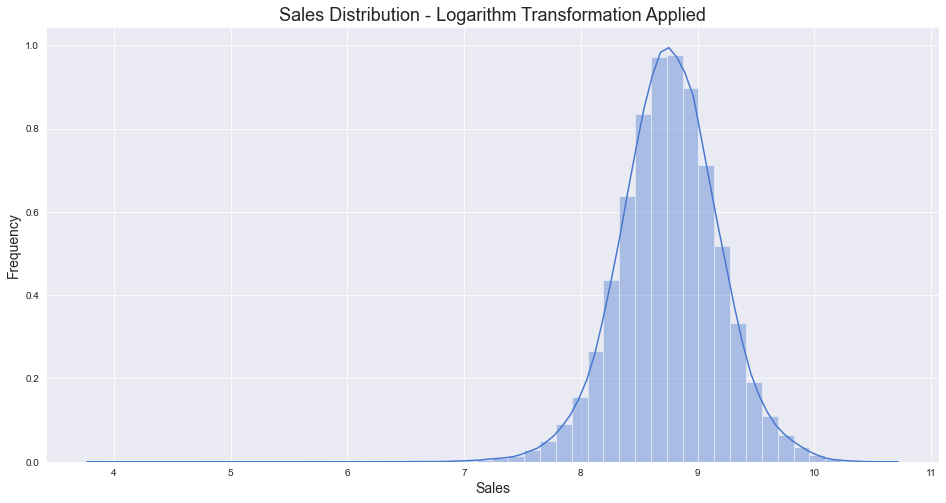

In [164]:
# uses the variable ax for single a Axes
fig, ax = plt.subplots()

# sets the figure size in inches
ax.figure.set_size_inches(16, 8)

# plots a box plot
ax = sns.distplot(df5['sales'])

# sets the plot features
set_plots_features(ax, "Sales Distribution - Logarithm Transformation Applied", "Sales", "Frequency")

# display the plot
plt.show()

### 5.3.2 Nature Transformation

In [168]:
# day_of_week
df5['day_of_week_sin'] = df5['day_of_week'].apply(lambda x: np.sin(x *(2. * np.pi / 7)))
df5['day_of_week_cos'] = df5['day_of_week'].apply(lambda x: np.cos(x *(2. * np.pi / 7)))

# month
df5['month_sin'] = df5['month'].apply(lambda x: np.sin(x *(2. * np.pi / 12)))
df5['month_cos'] = df5['month'].apply(lambda x: np.cos(x *(2. * np.pi / 12)))

# day
df5['day_sin'] = df5['day'].apply(lambda x: np.sin(x *(2. * np.pi / 30)))
df5['day_cos'] = df5['day'].apply(lambda x: np.cos(x *(2. * np.pi / 30)))

# week_of_year
df5['week_of_year_sin'] = df5['week_of_year'].apply(lambda x: np.sin(x *(2. * np.pi / 52)))
df5['week_of_year_cos'] = df5['week_of_year'].apply(lambda x: np.cos(x *(2. * np.pi / 52)))

In [169]:
# checks the dataset after operations
df5

,store,day_of_week,date,sales,promo,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week,before_after,state_holiday_christmas,state_holiday_easter_holiday,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_of_week_sin,day_of_week_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos
0,1,5,2015-07-31,8.568646,1,1,2,1,-0.170968,9,2008,0,31,2015,0,1.0,7,31,31,2015-30,2008-09-01,0.918919,2015-07-27,0.287016,after_10_days,0,0,0,1,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
1,2,5,2015-07-31,8.710290,1,1,0,1,-0.283871,11,2007,1,13,2010,1,1.0,7,31,31,2015-30,2007-11-01,1.054054,2010-03-22,0.922551,after_10_days,0,0,0,1,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
2,3,5,2015-07-31,9.025816,1,1,0,1,1.903226,12,2006,1,14,2011,1,1.0,7,31,31,2015-30,2006-12-01,1.202703,2011-03-28,0.801822,after_10_days,0,0,0,1,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
3,4,5,2015-07-31,9.546527,1,1,2,3,-0.275806,9,2009,0,31,2015,0,1.0,7,31,31,2015-30,2009-09-01,0.743243,2015-07-27,0.287016,after_10_days,0,0,0,1,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
4,5,5,2015-07-31,8.481151,1,1,0,1,4.448387,4,2015,0,31,2015,0,1.0,7,31,31,2015-30,2015-04-01,-0.162162,2015-07-27,0.287016,after_10_days,0,0,0,1,-0.5,-0.866025,-0.974928,-0.222521,0.207912,0.978148,-0.568065,-0.822984
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,8.124447,0,1,1,1,-0.351613,9,2006,0,1,2013,0,0.0,1,1,1,2013-00,2006-09-01,0.824324,2012-12-31,0.287016,before_10_days,0,0,1,0,0.5,0.866025,0.974928,-0.222521,0.207912,0.978148,0.120537,0.992709
1016827,733,2,2013-01-01,9.284148,0,1,1,2,-0.237097,10,1999,0,1,2013,0,0.0,1,1,1,2013-00,1999-10-01,1.959459,2012-12-31,0.287016,before_10_days,0,0,1,0,0.5,0.866025,0.974928,-0.222521,0.207912,0.978148,0.120537,0.992709
1016863,769,2,2013-01-01,8.524367,0,1,1,2,-0.240323,1,2013,1,48,2012,1,0.0,1,1,1,2013-00,2013-01-01,-0.216216,2012-11-19,0.300683,before_10_days,0,0,1,0,0.5,0.866025,0.974928,-0.222521,0.207912,0.978148,0.120537,0.992709
1017042,948,2,2013-01-01,8.410053,0,1,1,2,-0.145161,1,2013,0,1,2013,0,0.0,1,1,1,2013-00,2013-01-01,-0.216216,2012-12-31,0.287016,before_10_days,0,0,1,0,0.5,0.866025,0.974928,-0.222521,0.207912,0.978148,0.120537,0.992709
